<center><img src="https://raw.githubusercontent.com/mateuszk098/kaggle_notebooks/master/playground_series_s3e25/undraw_Developer_activity_re_39tg.png" width=400px></center>

# <p style="font-family: 'JetBrains Mono'; font-weight: bold; font-size: 125%; color: #4A4B52; text-align: center">Playground Series S3E25 - Mohs Hardness</p>

In [1]:
# %load ../utils/config.py
# !pip install -q kaleido
import glob
import operator
import os
import shutil
import subprocess
import sys
import warnings
from array import array
from collections import defaultdict, namedtuple
from copy import copy
from functools import partial, singledispatch
from itertools import chain, combinations, product
from pathlib import Path
from time import strftime

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.io as pio
import scipy.stats as stats
import seaborn as sns
import shap
from colorama import Fore, Style
from IPython.display import HTML, Image, display_html
from lightgbm import LGBMClassifier, LGBMRegressor
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from sklearn import clone
from sklearn.base import (
    BaseEstimator,
    ClassNamePrefixFeaturesOutMixin,
    MetaEstimatorMixin,
    OneToOneFeatureMixin,
    TransformerMixin,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import FeatureAgglomeration
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import (
    GradientBoostingRegressor,
    IsolationForest,
    RandomForestRegressor,
)
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LogisticRegression, SGDOneClassSVM
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding
from sklearn.metrics import (
    confusion_matrix,
    median_absolute_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
)
from sklearn.neighbors import KNeighborsRegressor, LocalOutlierFactor
from sklearn.pipeline import FunctionTransformer, make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, RobustScaler
from sklearn.svm import SVC, SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.utils.validation import check_array, check_is_fitted
from xgboost import XGBClassifier

# Environment
ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None

# Colorama settings.
CLR = (Style.BRIGHT + Fore.BLACK) if ON_KAGGLE else (Style.BRIGHT + Fore.WHITE)
RED = Style.BRIGHT + Fore.RED
BLUE = Style.BRIGHT + Fore.BLUE
CYAN = Style.BRIGHT + Fore.CYAN
MAGENTA = Style.BRIGHT + Fore.MAGENTA
RESET = Style.RESET_ALL

# Data Frame and Plotly colors.
FONT_COLOR = "#4A4B52"
BACKGROUND_COLOR = "#FFFCFA"
GRADIENT_COLOR = "#BAB8B8"
# Define as numpy array because it supports fancy indexing.
COLOR_SCHEME = np.array(("#4A4B52", "#FCFCFC", "#E8BA91"))
# Ticks size for plotly and matplotlib.
TICKSIZE = 11

# Set Plotly theme.
pio.templates["minimalist"] = go.layout.Template(
    layout=go.Layout(
        font_family="Open Sans",
        font_color=FONT_COLOR,
        title_font_size=20,
        plot_bgcolor=BACKGROUND_COLOR,
        paper_bgcolor=BACKGROUND_COLOR,
        xaxis=dict(tickfont_size=TICKSIZE, titlefont_size=TICKSIZE, showgrid=False),
        yaxis=dict(tickfont_size=TICKSIZE, titlefont_size=TICKSIZE, showgrid=False),
        width=840,
        height=540,
        legend=dict(yanchor="bottom", xanchor="right", orientation="h", title=""),
    ),
    layout_colorway=COLOR_SCHEME,
)
pio.templates.default = "plotly+minimalist"

MATPLOTLIB_THEME = {
    "axes.labelcolor": FONT_COLOR,
    "axes.labelsize": TICKSIZE,
    "axes.facecolor": BACKGROUND_COLOR,
    "axes.titlesize": 14,
    "axes.grid": False,
    "xtick.labelsize": TICKSIZE,
    "xtick.color": FONT_COLOR,
    "ytick.labelsize": TICKSIZE,
    "ytick.color": FONT_COLOR,
    "figure.facecolor": BACKGROUND_COLOR,
    "figure.edgecolor": BACKGROUND_COLOR,
    "figure.titlesize": 14,
    "figure.dpi": 72,  # Locally Seaborn uses 72, meanwhile Kaggle 96.
    "text.color": FONT_COLOR,
    "font.size": TICKSIZE,
    "font.family": "Serif",
}
sns.set_theme(rc=MATPLOTLIB_THEME)

# Define Data Frame theme.
CELL_HOVER = {  # for row hover use <tr> instead of <td>
    "selector": "td:hover",
    "props": f"background-color: {BACKGROUND_COLOR}",
}
TEXT_HIGHLIGHT = {
    "selector": "td",
    "props": f"color: {FONT_COLOR}; font-weight: bold",
}
INDEX_NAMES = {
    "selector": ".index_name",
    "props": f"font-weight: normal; background-color: {BACKGROUND_COLOR}; color: {FONT_COLOR};",
}
HEADERS = {
    "selector": "th:not(.index_name)",
    "props": f"font-weight: normal; background-color: {BACKGROUND_COLOR}; color: {FONT_COLOR};",
}
DF_STYLE = (INDEX_NAMES, HEADERS, TEXT_HIGHLIGHT)
DF_CMAP = sns.light_palette(GRADIENT_COLOR, as_cmap=True)

# Html style for table of contents, code highlight and url.
HTML_STYLE = """
    <style>
    code {
        background: rgba(42, 53, 125, 0.10) !important;
        border-radius: 4px !important;
    }
    a {
        color: rgba(123, 171, 237, 1.0) !important;
    }
    ol.numbered-list {
        counter-reset: item;
    }
    ol.numbered-list li {
        display: block;
    }
    ol.numbered-list li:before {
        content: counters(item, '.') '. ';
        counter-increment: item;
    }
    </style>
"""


# Utility functions.
def download_from_kaggle(expr, /, data_dir=None):
    """Download all files from the Kaggle competition/dataset.

    Args:
        expr: Match expression to be used by kaggle API, e.g.
            "kaggle competitions download -c competition" or
            "kaggle datasets download -d user/dataset".
        data_dir: Optional. Directory path where to save files. Default to `None`,
        which means that files will be downloaded to `data` directory.

    Notes:
        If the associated files already exists, then it does nothing.
    """

    if data_dir is None:
        data_dir = Path("data/")
    else:
        data_dir = Path(data_dir)

    match expr.split():
        case ["kaggle", _, "download", *args] if args:
            data_dir.mkdir(parents=True, exist_ok=True)
            filename = args[-1].split("/")[-1] + ".zip"
            if not (data_dir / filename).is_file():
                subprocess.run(expr)
                shutil.unpack_archive(filename, data_dir)
                shutil.move(filename, data_dir)
        case _:
            raise SyntaxError("Invalid expression!")


def get_interpolated_colors(color1, color2, /, n_colors=1):
    """Return `n_colors` colors in HEX format, interpolated beetwen `color1` and `color2`.

    Args:
        color1: Initial HEX color to be interpolated from.
        color2: Final HEX color to be interpolated from.
        n_colors: Optional. Number of colors to be interpolated between `color1`
            and `color2`. Default to 1.

    Returns:
        colors: List of colors interpolated between `color1` and `color2`.
    """

    def interpolate(color1, color2, t):
        r1, g1, b1 = int(color1[1:3], 16), int(color1[3:5], 16), int(color1[5:7], 16)
        r2, g2, b2 = int(color2[1:3], 16), int(color2[3:5], 16), int(color2[5:7], 16)
        r = int(r1 + (r2 - r1) * t)
        g = int(g1 + (g2 - g1) * t)
        b = int(b1 + (b2 - b1) * t)
        return f"#{r:02X}{g:02X}{b:02X}"

    return [interpolate(color1, color2, k / (n_colors + 1)) for k in range(1, n_colors + 1)]


def get_pretty_frame(frame, /, gradient=False, formatter=None, precision=3, repr_html=False):
    stylish_frame = frame.style.set_table_styles(DF_STYLE).format(
        formatter=formatter, precision=precision
    )
    if gradient:
        stylish_frame = stylish_frame.background_gradient(DF_CMAP)  # type: ignore
    if repr_html:
        stylish_frame = stylish_frame.set_table_attributes("style='display:inline'")._repr_html_()
    return stylish_frame


def numeric_descr(frame, /):
    return (
        frame.describe(percentiles=(0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99))
        .T.drop("count", axis=1)
        .rename(columns=str.title)
    )


def frame_summary(frame, /):
    missing_vals = frame.isna().sum()
    missing_vals_ratio = missing_vals / len(frame)
    unique_vals = frame.apply(lambda col: len(col.unique()))
    most_freq_count = frame.apply(lambda col: col.value_counts().iloc[0])
    most_freq_val = frame.mode().iloc[:1].T.squeeze()
    unique_ratio = unique_vals / len(frame)
    freq_count_ratio = most_freq_count / len(frame)

    return pd.DataFrame(
        {
            "Dtype": frame.dtypes,
            "MissingValues": missing_vals,
            "MissingValuesRatio": missing_vals_ratio,
            "UniqueValues": unique_vals,
            "UniqueValuesRatio": unique_ratio,
            "MostFreqValue": most_freq_val,
            "MostFreqValueCount": most_freq_count,
            "MostFreqValueCountRatio": freq_count_ratio,
        }
    )


def check_categories_alignment(frame1, frame2, /, out_color=BLUE):
    print(CLR + "The same categories in training and test datasets?\n")
    cat_features = frame2.select_dtypes(include="object").columns.to_list()

    for feature in cat_features:
        frame1_unique = set(frame1[feature].unique())
        frame2_unique = set(frame2[feature].unique())
        same = np.all(frame1_unique == frame2_unique)
        print(CLR + f"{feature:25s}", out_color + f"{same}")


def get_lower_triangular_frame(frame, /):
    if not frame.shape[0] == frame.shape[1]:
        raise ValueError(f"{type(frame)!r} is not square frame")
    lower_triu = np.triu(np.ones_like(frame, dtype=bool))
    frame = frame.mask(lower_triu)
    return frame.dropna(axis="index", how="all").dropna(axis="columns", how="all")


def save_and_show_fig(fig, filename, /, img_dir=None, format="png"):
    if img_dir is None:
        img_dir = Path("images")
    if not isinstance(img_dir, Path):
        raise TypeError("The `img_dir` argument must be `Path` instance!")

    img_dir.mkdir(parents=True, exist_ok=True)
    fig_path = img_dir / (filename + "." + format)
    fig.write_image(fig_path)

    return Image(fig.to_image(format=format))


def get_n_rows_and_axes(n_features, n_cols, /, start_at=1):
    n_rows = int(np.ceil(n_features / n_cols))
    current_col = range(start_at, n_cols + start_at)
    current_row = range(start_at, n_rows + start_at)
    return n_rows, tuple(product(current_row, current_col))


def get_kde_estimation(
    series,
    *,
    bw_method=None,
    weights=None,
    percentile_range=(0, 100),
    estimate_points_frac=0.1,
    space_extension_frac=0.01,
    cumulative=False,
):
    """Return pdf dictionary for set of points using gaussian kernel density estimation.

    Args:
        series: The dataset with which `stats.gaussian_kde` is initialized.
        bw_method: Optional. The method used to calculate the estimator bandwidth.
        This can be 'scott', 'silverman', a scalar constant or a callable. If a scalar,
        this will be used directly as `kde.factor`. If a callable, it should take
        a `stats.gaussian_kde` instance as only parameter and return a scalar.
        If `None` (default), 'scott' is used.
        weights: Optional. Weights of datapoints. This must be the same shape as dataset.
        If `None` (default), the samples are assumed to be equally weighted.
        percentile_range: Optional. Percentile range of the `series` to create estimated space.
        By default (0, 100) range is used.
        estimate_points_frac: Optional. Fraction of `series` length to create linspace for
        estimated points.
        space_extension_frac: Optional. Estimation space will be extended by
        `space_extension_frac * len(series)` for both edges.
        cumulative: Optional. Whether to calculate cdf. Default to `False`.

    Returns:
        Dictionary with kde space, values, and cumulative values if `cumulative` is `True`.
    """

    series = pd.Series(series).dropna()
    kde = stats.gaussian_kde(series, bw_method=bw_method, weights=weights)
    start, stop = np.percentile(series, percentile_range)

    n_points = int(estimate_points_frac * len(series))
    n_extend = int(space_extension_frac * len(series))

    if n_extend > 0:
        dx = (stop - start) / (n_points - 1)
        start, stop = start - n_extend * dx, stop + n_extend * dx

    kde_space = np.linspace(start, stop, n_points)
    kde_vals = kde.evaluate(kde_space)
    results = {"space": kde_space, "vals": kde_vals}

    if cumulative:
        kde_vals_cum = np.cumsum(kde_vals)
        return results | {"vals_cumulative": kde_vals_cum / kde_vals_cum.max()}

    return results


def unit_norm(x):
    return x / np.sum(x)


# Html highlight. Must be included at the end of all imports!
HTML(HTML_STYLE)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Competition Description</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The dataset for this competition (both train and test) was generated from a deep learning model trained on the <a href="https://www.kaggle.com/datasets/jocelyndumlao/prediction-of-mohs-hardness-with-machine-learning"><b>Prediction of Mohs Hardness with Machine Learning Dataset</b></a>. Feature distributions are close to, but not exactly the same, as the original. Full description of the original dataset is as follows.:<br><br>
    <i>Hardness, or the quantitative value of resistance to permanent or plastic deformation, plays a very crucial role in materials design in many applications, such as ceramic coatings and abrasives. Hardness testing is an especially useful method as it is non-destructive and simple to implement to gauge the plastic properties of a material. In this study, I proposed a machine, or statistical, learning approach to predict hardness in naturally occurring materials, which integrates atomic and electronic features from composition directly across a wide variety of mineral compositions and crystal systems. First, atomic and electronic features from the composition, such as van der Waals and covalent radii as well as the number of valence electrons, were extracted from the composition.<br><br>
    In this study, the author trained a set of classifiers to understand whether compositional features can be used to predict the Mohs hardness of minerals of different chemical spaces, crystal structures, and crystal classes. The dataset for training and testing the classification models used in this study originated from experimental Mohs hardness data, their crystal classes, and chemical compositions of naturally occurring minerals reported in the Physical and Optical Properties of Minerals CRC Handbook of Chemistry and Physics and the American Mineralogist Crystal Structure Database. The database is composed of 369 uniquely named minerals. Due to the presence of multiple composition combinations for minerals referred to by the same name, the first step was to perform compositional permutations on these minerals. This produced a database of 622 minerals of unique compositions, comprising 210 monoclinic, 96 rhombohedral, 89 hexagonal, 80 tetragonal, 73 cubic, 50 orthorhombic, 22 triclinic, 1 trigonal, and 1 amorphous structure. An independent dataset was compiled to validate the model performance. The validation dataset contains the composition, crystal structure, and Mohs hardness values of 51 synthetic single crystals reported in the literature. The validation dataset includes 15 monoclinic, 7 tetragonal, 7 hexagonal, 6 orthorhombic, 4 cubic, and 3 rhombohedral crystal structures.<br><br>
    In this study, the author constructed a database of compositional feature descriptors that characterize naturally occurring materials obtained directly from the Physical and Optical Properties of Minerals CRC Handbook45. This comprehensive compositional-based dataset allows us to train models that are able to predict hardness across a wide variety of mineral compositions and crystal classes. Each material in both the naturally occurring mineral and artificial single crystal datasets was represented by 11 atomic descriptors. The elemental features are the number of electrons, number of valence electrons, atomic number, Pauling electronegativity of the most common oxidation state, covalent atomic radii, van der Waals radii, and ionization energy of neutral.</i><br><br>
    <b>More in the paper: <a href="https://par.nsf.gov/servlets/purl/10187152">Prediction of Mohs Hardness with Machine Learning Methods Using Compositional Features</a></b>
</p>
    
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Task</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    This is a regression problem, where the main task is to predict the <code>Hardness</code> feature. The competition evaluation metric is <a href="https://en.wikipedia.org/wiki/Median_absolute_deviation"><b>Median Absolute Error (MedAE)</b></a>:
    \[\textrm{MedAE} =\textrm{median}\left(|y_i - \hat{y}_i|, \ldots, |y_n - \hat{y}_n|\right),\]
    where $\hat{y}_i$ is the predicted value and $y_i$ is the ground truth for each observation.
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Table of Contents</b> 📔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The table of contents provides pleasurable navigation through the whole notebook. You can easily navigate through sections and return to TOC. If you want quickly find out something about the dataset, just read the first section, i.e. <b>Quick Overview</b>.
</p>

<blockquote class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
    background-color: #E8BA91;
    border-radius: 2px;
    border: 1px solid #E8BA91;
">
<ol class="numbered-list" style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #F2F2F0;
    margin-top: 15px;
    margin-bottom: 15px;
">
    <li><a href="#quick_overview"><span style="color: #F2F2F0">Quick Overview</span></a>
        <ol class="numbered-list" class="numbered-list" style="
            font-size: 16px;
            font-family: 'JetBrains Mono';
        ">
            <li><a href="#data_reading_and_features_description"><span style="color: #F2F2F0">Data Reading &amp; Features Description</span></a></li>
            <li><a href="#basic_numerical_properties_summaries"><span style="color: #F2F2F0">Basic Numerical Properties &amp; Summaries</span></a></li>
            <li><a href="#probability_plots_and_example_transformations"><span style="color: #F2F2F0">Probability Plots &amp; Example Transformations</span></a></li>
        </ol>
    </li>
    <li><a href="#features_importance"><span style="color: #F2F2F0">Features Importance</span></a>
        <ol class="numbered-list" class="numbered-list" style="
            font-size: 16px;
            font-family: 'JetBrains Mono';
        ">
            <li><a href="#simple_decision_tree_and_its_decision_process"><span style="color: #F2F2F0">Decision Process in Simple Decision Tree</span></a></li>
            <li><a href="#random_variables_permutation_test"><span style="color: #F2F2F0">Random Variables &amp; Permutation Test</span></a></li>
            <li><a href="#mutual_information"><span style="color: #F2F2F0">Mutual Information</span></a></li>
            <li><a href="#partial_dependence_for_features_of_interest"><span style="color: #F2F2F0">Partial Dependence for Features of Interest</span></a></li>
        </ol>
    </li>
    <li><a href="#dimensionality_reduction"><span style="color: #F2F2F0">Dimensionality Reduction</span></a></li>
    <li><a href="#outliers_detection"><span style="color: #F2F2F0">Outliers Detection</span></a></li>
    <li><a href="#modelling"><span style="color: #F2F2F0">Modelling</span></a>
        <ol class="numbered-list" class="numbered-list" style="
            font-size: 16px;
            font-family: 'JetBrains Mono';
        ">
            <li><a href="#regression_approach"><span style="color: #F2F2F0">Regression Approach</span></a></li>
            <li><a href="#multiclass_classification_approach"><span style="color: #F2F2F0">Multiclass Classification Approach</span></a></li>
        </ol>
    </li>
    <li><a href="#summary"><span style="color: #F2F2F0">Summary</span></a></li>
</ol>
</blockquote>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Quick Overview</span></b><a class="anchor" id="quick_overview"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>About Section</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In this section, I provide a quick overview of the dataset. More detailed analysis will be done in subsequent sections.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.1</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Data Reading &amp; Features Description</span></b><a class="anchor" id="data_reading_and_features_description"></a> [↑](#top)

In [2]:
competition = "playground-series-s3e25"
expr = f"kaggle competitions download -c {competition}"

if not ON_KAGGLE:
    download_from_kaggle(expr)
    train_path = "data/train.csv"
    test_path = "data/test.csv"
else:
    train_path = f"/kaggle/input/{competition}/train.csv"
    test_path = f"/kaggle/input/{competition}/test.csv"

train = pd.read_csv(train_path, index_col="id")  # .rename(columns=str.title)
test = pd.read_csv(test_path, index_col="id")  # .rename(columns=str.title)

In [3]:
get_pretty_frame(train.head())

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
id,,,,,,,,,,,,
0,100.000,0.842,10.000,4.800,20.613,11.088,2.766,1.732,0.860,0.496,0.915,6.000
1,100.000,7.558,10.000,4.800,20.299,12.041,2.755,1.631,0.910,0.493,0.718,6.500
2,76.000,8.886,15.600,5.600,33.739,12.086,2.828,1.788,0.864,0.481,1.506,2.500
3,100.000,8.795,10.000,4.800,20.213,10.948,2.648,1.626,0.936,0.489,0.789,6.000
4,116.000,9.578,11.600,4.800,24.988,11.824,2.766,1.682,0.896,0.493,1.865,6.000


In [4]:
train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 10407 entries, 0 to 10406
Columns: 12 entries, allelectrons_Total to Hardness
dtypes: float64(12)
memory usage: 1.0 MB


In [5]:
test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 6939 entries, 10407 to 17345
Columns: 11 entries, allelectrons_Total to density_Average
dtypes: float64(11)
memory usage: 650.5 KB


<p style="  
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
  <b>Features Description</b> 📔
</p>

<center>
<table style="
  padding: 10px;
  border-radius: 2px;
  border: 4px solid #4A4B52;
  font-family: 'JetBrains Mono';
  font-size: 16px;
  width: 100%";
>
  <tr>
    <th>Feature</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>allelectrons_Total</td>
    <td>Total number of electrons.</td>
  </tr>
  <tr>
    <td>density_Total</td>
    <td>Total elemental density.</td>
  </tr>
  <tr>
    <td>allelectrons_Average</td>
    <td>Atomic average number of electrons.</td>
  </tr>
  <tr>
    <td>val_e_Average</td>
    <td>Atomic average number of valence electrons.</td>
  </tr>
  <tr>
    <td>atomicweight_Average</td>
    <td>Atomic average atomic weight.</td>
  </tr>
  <tr>
    <td>ionenergy_Average</td>
    <td>Atomic average frst IE (ionization energy).</td>
  </tr>
  <tr>
    <td>el_neg_chi_Average</td>
    <td>Atomic average Pauling electronegativity of the most common oxidation state.</td>
  </tr>
  <tr>
    <td>R_vdw_element_Average</td>
    <td>Atomic average van der Waals atomic radius.</td>
  </tr>
  <tr>
    <td>R_cov_element_Average</td>
    <td>Atomic average covalent atomic radius.</td>
  </tr>
  <tr>
    <td>zaratio_Average</td>
    <td>Atomic average atomic number to mass number ratio.</td>
  </tr>
  <tr>
    <td>density_Average</td>
    <td>Atomic average elemental density.</td>
  </tr>
  <tr>
    <td>Hardness</td>
    <td>A mineral's hardness is a measure of its relative resistance to scratching, measured by scratching the mineral against another substance of known hardness on the Mohs Hardness Scale.</td>
  </tr>
</table>
</center>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    So, here we've got $11$ continuous features and a continuous target. Moreover, there are $10407$ samples in the training data and $6939$ in the test dataset. This gives $946$ entries per dimension during training, so there should be enough data to learn patterns. Let's get to the basic numerical summaries.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.2</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Basic Numerical Properties &amp; Summaries</span></b><a class="anchor" id="basic_numerical_properties_summaries"></a> [↑](#top)

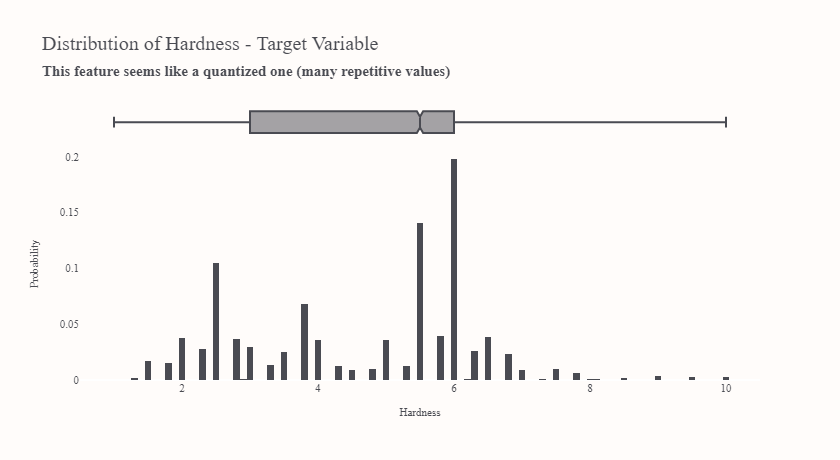

In [6]:
fig = px.histogram(
    train,
    x="Hardness",
    histnorm="probability",
    marginal="box",
    height=460,
    title="Distribution of Hardness - Target Variable<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "This feature seems like a quantized one (many repetitive values)</span>",
)
fig.update_yaxes(title="Probability", row=1)
save_and_show_fig(fig, "hardness_distribution")

In [7]:
print(CLR + "Training Dataset:")
train_summary = frame_summary(train)
get_pretty_frame(train_summary, gradient=True)

Training Dataset:


,Dtype,MissingValues,MissingValuesRatio,UniqueValues,UniqueValuesRatio,MostFreqValue,MostFreqValueCount,MostFreqValueCountRatio
allelectrons_Total,float64,0,0.000,325,0.031,100.000,822,0.079
density_Total,float64,0,0.000,1099,0.106,8.148,237,0.023
allelectrons_Average,float64,0,0.000,629,0.060,10.000,1602,0.154
val_e_Average,float64,0,0.000,205,0.020,4.800,2858,0.275
atomicweight_Average,float64,0,0.000,849,0.082,20.299,316,0.030
ionenergy_Average,float64,0,0.000,898,0.086,11.330,354,0.034
el_neg_chi_Average,float64,0,0.000,745,0.072,2.706,289,0.028
R_vdw_element_Average,float64,0,0.000,737,0.071,1.717,274,0.026
R_cov_element_Average,float64,0,0.000,698,0.067,0.910,344,0.033
zaratio_Average,float64,0,0.000,815,0.078,0.493,267,0.026


In [8]:
print(CLR + "Test Dataset:")
test_summary = frame_summary(test)
get_pretty_frame(test_summary, gradient=True)

Test Dataset:


,Dtype,MissingValues,MissingValuesRatio,UniqueValues,UniqueValuesRatio,MostFreqValue,MostFreqValueCount,MostFreqValueCountRatio
allelectrons_Total,float64,0,0.000,263,0.038,100.000,593,0.085
density_Total,float64,0,0.000,904,0.130,7.558,165,0.024
allelectrons_Average,float64,0,0.000,514,0.074,10.000,1094,0.158
val_e_Average,float64,0,0.000,185,0.027,4.800,1939,0.279
atomicweight_Average,float64,0,0.000,728,0.105,20.299,223,0.032
ionenergy_Average,float64,0,0.000,699,0.101,11.330,254,0.037
el_neg_chi_Average,float64,0,0.000,643,0.093,2.706,230,0.033
R_vdw_element_Average,float64,0,0.000,622,0.090,1.742,186,0.027
R_cov_element_Average,float64,0,0.000,592,0.085,0.910,240,0.035
zaratio_Average,float64,0,0.000,660,0.095,0.493,171,0.025


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Missing &amp; Unique &amp; Most Frequent Values</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    What's surprising there is no missing values, so we don't need to bother about imputation. We can see the ratio of unique values in both datasets is quite low for all features, which means that features consist of many repeatable values. This makes them more semi-continuous rather than continuous. The target variable has only $50$ unique values among more than $10000$ training samples, and in my opinion, it's more like a categorical feature.
</p>

In [9]:
print(CLR + "Training Dataset:")
train_num_descr = numeric_descr(train)
get_pretty_frame(train_num_descr, gradient=True)

Training Dataset:


,Mean,Std,Min,1%,5%,25%,50%,75%,95%,99%,Max
allelectrons_Total,128.054,224.124,0.000,6.000,36.000,68.000,100.000,131.000,278.000,719.400,15300.000
density_Total,14.491,15.973,0.000,0.740,2.333,7.558,10.650,16.677,37.007,75.099,643.094
allelectrons_Average,17.033,10.469,0.000,4.667,7.500,10.000,12.600,22.000,42.000,50.000,67.000
val_e_Average,4.547,0.691,0.000,2.000,3.500,4.000,4.714,4.800,5.600,5.667,6.000
atomicweight_Average,37.508,26.012,0.000,8.773,14.997,20.299,26.204,48.719,98.341,119.629,167.400
ionenergy_Average,10.938,1.408,0.000,8.054,9.014,10.591,11.203,11.671,12.373,13.513,15.246
el_neg_chi_Average,2.608,0.335,0.000,1.790,2.045,2.530,2.706,2.805,2.902,2.980,3.443
R_vdw_element_Average,1.731,0.192,0.000,1.319,1.518,1.673,1.733,1.800,1.943,2.055,2.250
R_cov_element_Average,0.944,0.180,0.000,0.505,0.708,0.864,0.916,0.982,1.233,1.390,1.616
zaratio_Average,0.493,0.063,0.000,0.405,0.448,0.476,0.489,0.496,0.616,0.707,0.826


In [10]:
print(CLR + "Test Dataset:")
test_num_descr = numeric_descr(test)
get_pretty_frame(test_num_descr, gradient=True)

Test Dataset:


,Mean,Std,Min,1%,5%,25%,50%,75%,95%,99%,Max
allelectrons_Total,126.460,207.564,0.000,14.000,33.000,68.000,100.000,128.000,278.000,710.000,10116.000
density_Total,14.794,18.982,0.000,0.772,2.333,7.558,10.650,16.601,37.777,105.514,643.094
allelectrons_Average,17.406,10.996,0.000,4.667,7.500,10.000,12.667,22.000,42.800,50.000,67.000
val_e_Average,4.547,0.683,0.000,2.025,3.500,4.000,4.750,4.800,5.600,5.800,6.000
atomicweight_Average,38.423,27.344,0.000,8.773,14.997,20.299,26.204,48.719,103.499,119.629,167.400
ionenergy_Average,10.922,1.379,0.000,8.054,8.917,10.584,11.203,11.646,12.302,13.513,15.246
el_neg_chi_Average,2.608,0.323,0.000,1.903,2.045,2.527,2.706,2.807,2.902,2.980,3.443
R_vdw_element_Average,1.738,0.191,0.000,1.319,1.542,1.678,1.736,1.820,1.980,2.087,2.250
R_cov_element_Average,0.950,0.179,0.000,0.520,0.710,0.867,0.920,0.990,1.253,1.390,1.615
zaratio_Average,0.492,0.061,0.000,0.403,0.446,0.476,0.489,0.496,0.614,0.696,0.826


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Numerical Summary</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Here we have two features with some outliers. These are <code>allelectrons_Total</code> and <code>density_Total</code>. Nevertheless, both datasets overlap (see respective percentiles in both cases) for all attributes. It is most probable that they come from the same distribution.<br><br>
    Let's test the last consideration with <b>adversarial validation</b>. What is the adversarial validation? <b>Well, it's a very straightforward way to check whether our subsets are similar (sampled from the same or very similar distributions).</b> We label training and test datasets with, for example, $0$ and $1$. Then, we combine them into one dataset and shuffle them. Subsequently, we can perform binary classification and assess if we're able to identify which observation is from which dataset. When we get a ROC value of around $0.5$ (random guessing), they are indistinguishable, and this case is desired. On the other hand, when ROC $>0.5$, it probably means that training and test subsets are from different distributions.
</p>

In [11]:
train_av = train.drop("Hardness", axis=1).assign(AV=0)
test_av = test.assign(AV=1)

data_av = pd.concat((train_av, test_av), ignore_index=True)
data_av = data_av.sample(frac=1.0, random_state=42)

X = data_av.drop("AV", axis=1)
y = data_av.AV

y_proba = cross_val_predict(
    estimator=make_pipeline(StandardScaler(), LogisticRegression(random_state=42)),
    X=X,
    y=y,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=19937),
    method="predict_proba",
)

av_scores = {
    "ConfusionMatrix": confusion_matrix(y, y_proba.argmax(axis=1)),
    "FPR-TPR-Threshold": roc_curve(y, y_proba[:, 1]),
    "ROC-AUC": roc_auc_score(y, y_proba[:, 1]),
}

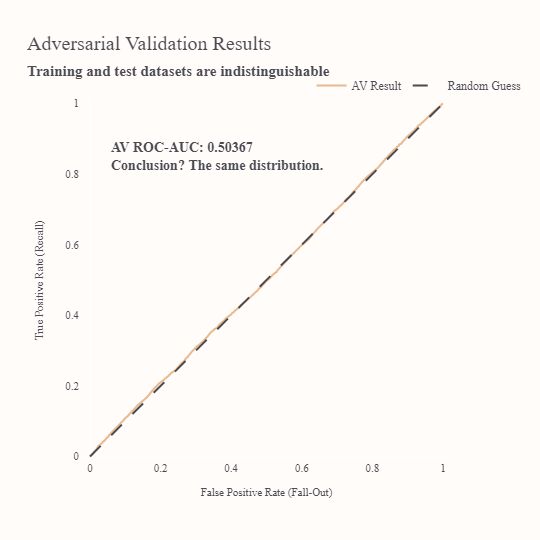

In [12]:
fig = go.Figure()
fig.add_scatter(
    x=av_scores["FPR-TPR-Threshold"][0],
    y=av_scores["FPR-TPR-Threshold"][1],
    name="AV Result",
    mode="lines",
    line_color=COLOR_SCHEME[2],
)
fig.add_scatter(
    x=[0, 1],
    y=[0, 1],
    name="Random Guess",
    mode="lines",
    line=dict(dash="longdash", color=COLOR_SCHEME[0]),
)
fig.add_annotation(
    x=0.05,
    y=0.85,
    align="left",
    xanchor="left",
    text=f"<b>AV ROC-AUC: {av_scores['ROC-AUC']:.5f}<br>" "Conclusion? The same distribution.",
    showarrow=False,
    font_size=14,
)
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
    range=(-0.01, 1.01),
    title="True Positive Rate (Recall)",
)
fig.update_xaxes(
    scaleanchor="y",
    scaleratio=1,
    range=(-0.01, 1.01),
    title="False Positive Rate (Fall-Out)",
)
fig.update_layout(
    title="Adversarial Validation Results<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Training and test datasets are indistinguishable</span>",
    width=540,
    legend=dict(y=1.0, x=1.2),
)
save_and_show_fig(fig, "adversarial_validation")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Adversarial Validation Results</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    So, the result is excellent for us since ROC $\approx 0.5$ means that subsets are indistinguishable (they come from the same distribution). Let's see histograms yet.
</p>

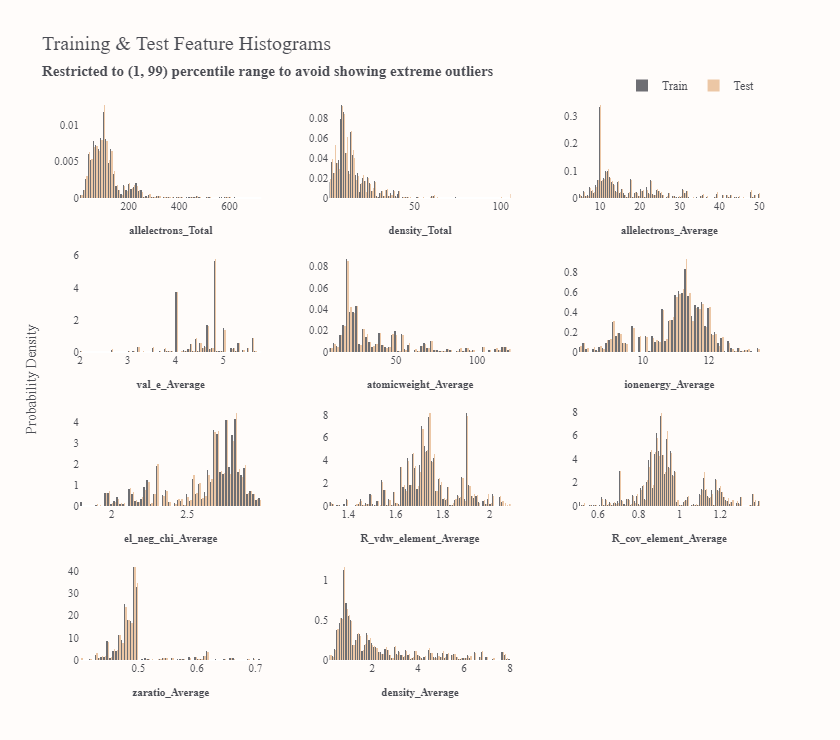

In [13]:
features = test.columns.to_list()

n_cols = 3
n_rows, axes = get_n_rows_and_axes(len(features), n_cols)

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    y_title="Probability Density",
    horizontal_spacing=0.1,
    vertical_spacing=0.1,
).update_annotations(font_size=14)

for frame, color, group in zip((train, test), (COLOR_SCHEME[0], COLOR_SCHEME[2]), ("Train", "Test")):
    for k, (var, (row, col)) in enumerate(zip(features, axes), start=1):
        start, end = np.percentile(frame[var], (1, 99))
        fig.add_histogram(
            x=frame[var],
            xbins=go.histogram.XBins(start=start, end=end),
            histnorm="probability density",
            marker_color=color,
            marker_line_width=0,
            opacity=0.8,
            name=group,
            legendgroup=group,
            showlegend=k == 1,
            row=row,
            col=col,
        )
        fig.update_xaxes(title_text=f"<b>{var}</b>", row=row, col=col)

fig.update_layout(
    width=840,
    height=740,
    legend=dict(y=1, x=1),
    title="Training & Test Feature Histograms<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Restricted to (1, 99) percentile range to avoid showing extreme outliers</span>",
    bargap=0,
    bargroupgap=0,
)
save_and_show_fig(fig, "histograms")

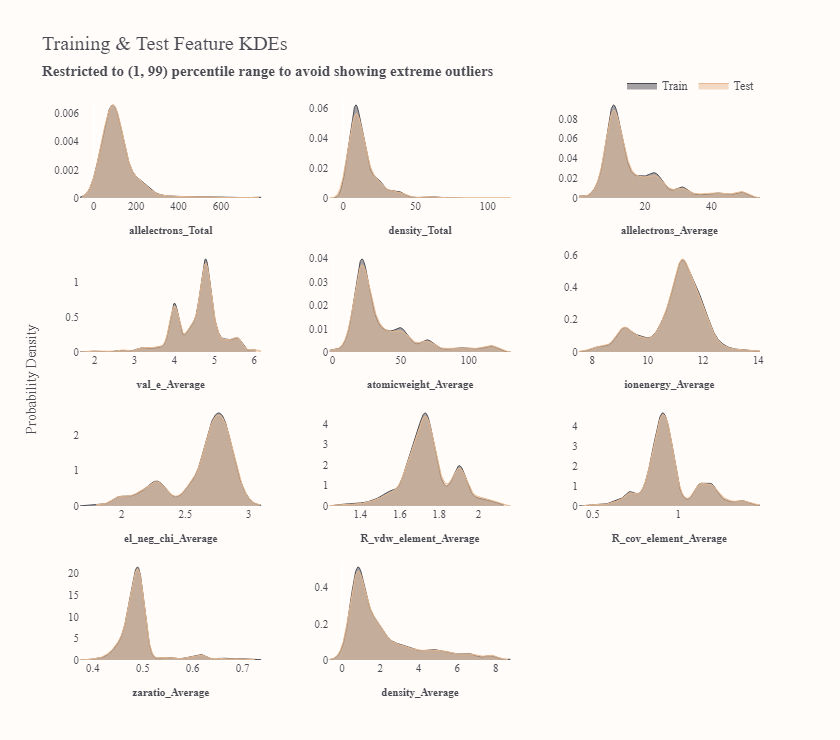

In [14]:
n_cols = 3
n_rows, axes = get_n_rows_and_axes(len(features), n_cols)

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    y_title="Probability Density",
    horizontal_spacing=0.1,
    vertical_spacing=0.1,
).update_annotations(font_size=14)

for frame, color, group in zip((train, test), (COLOR_SCHEME[0], COLOR_SCHEME[2]), ("Train", "Test")):
    for k, (var, (row, col)) in enumerate(zip(features, axes), start=1):
        kde = get_kde_estimation(frame[var], percentile_range=(1, 99))
        fig.add_scatter(
            x=kde["space"],
            y=kde["vals"],
            line=dict(dash="solid", color=color, width=1),
            fill="tozeroy",
            name=group,
            legendgroup=group,
            showlegend=k == 1,
            row=row,
            col=col,
        )
        fig.update_xaxes(title_text=f"<b>{var}</b>", row=row, col=col)

fig.update_layout(
    width=840,
    height=740,
    legend=dict(y=1, x=1),
    title="Training & Test Feature KDEs<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Restricted to (1, 99) percentile range to avoid showing extreme outliers</span>",
)
save_and_show_fig(fig, "kdes")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Feature Distributions</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Feature distributions confirm the previous statement, i.e. training and test subsets probably follow the same distribution, which is reflected as bins overlapping and similar density estimation. Let's continue analysis with correlation matrix and hierarchical clustering. 
</p>

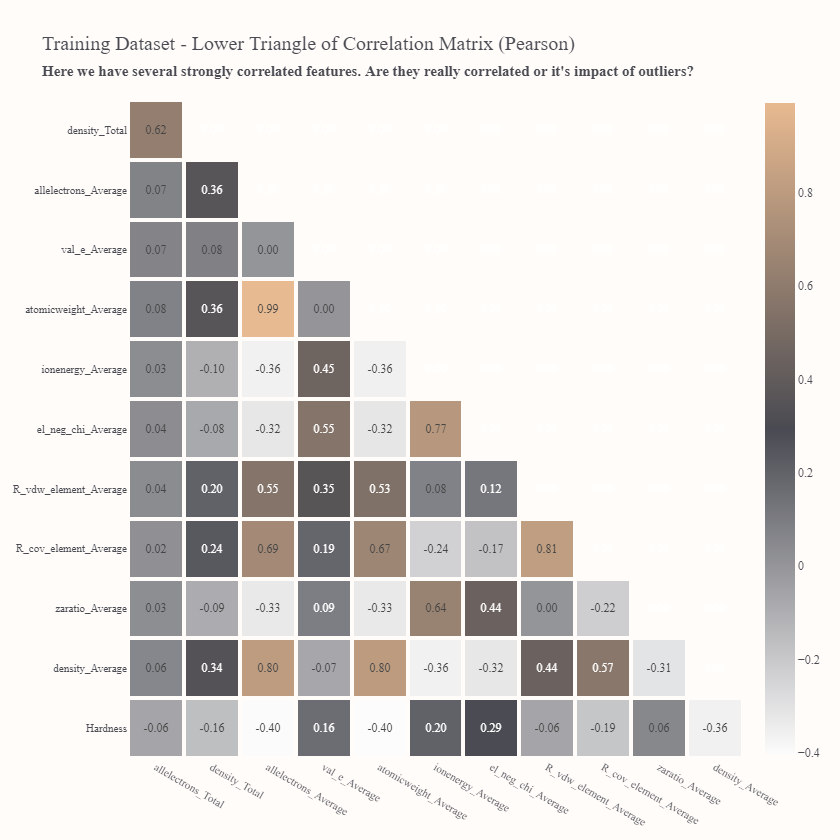

In [15]:
pearson_corr = train.corr(method="pearson")
lower_triu_corr = get_lower_triangular_frame(pearson_corr)
colormap = tuple(zip((0, 0.5, 1), COLOR_SCHEME[[1, 0, 2]]))

heatmap = go.Heatmap(
    z=lower_triu_corr,
    x=lower_triu_corr.columns,
    y=lower_triu_corr.index,
    text=lower_triu_corr.fillna(""),
    texttemplate="%{text:.2f}",
    xgap=4,
    ygap=4,
    showscale=True,
    colorscale=colormap,
    colorbar_len=1.02,
    hoverinfo="none",
)
fig = go.Figure(heatmap)
fig.update_layout(
    title="Training Dataset - Lower Triangle of Correlation Matrix (Pearson)<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Here we have several strongly correlated features. "
    "Are they really correlated or it's impact of outliers?</span>",
    yaxis_autorange="reversed",
    width=840,
    height=840,
)
save_and_show_fig(fig, "pearson_corr_matrix")

In [16]:
abs_corr = (
    lower_triu_corr.abs()
    .unstack()
    .sort_values(ascending=False)  # type: ignore
    .rename("Absolute Pearson Correlation")
    .to_frame()
    .reset_index(names=["Feature 1", "Feature 2"])
    .dropna()
    .round(5)
)

with pd.option_context("display.max_rows", 10):
    print(abs_corr)

                Feature 1              Feature 2  Absolute Pearson Correlation
0    allelectrons_Average   atomicweight_Average                       0.99066
1   R_vdw_element_Average  R_cov_element_Average                       0.81182
2    allelectrons_Average        density_Average                       0.80364
3    atomicweight_Average        density_Average                       0.79656
4       ionenergy_Average     el_neg_chi_Average                       0.77405
..                    ...                    ...                           ...
61     allelectrons_Total        zaratio_Average                       0.03104
62     allelectrons_Total  R_cov_element_Average                       0.02442
63   allelectrons_Average          val_e_Average                       0.00438
64  R_vdw_element_Average        zaratio_Average                       0.00298
65          val_e_Average   atomicweight_Average                       0.00186

[66 rows x 3 columns]


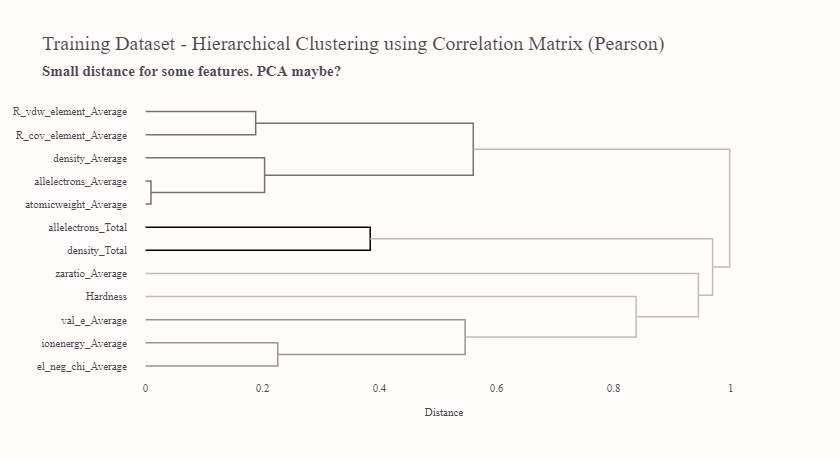

In [17]:
dissimilarity = 1 - np.abs(pearson_corr)

fig = ff.create_dendrogram(
    dissimilarity,
    labels=pearson_corr.columns,
    orientation="left",
    colorscale=px.colors.sequential.Greys[3:],
    # squareform() returns lower triangular in compressed form - as 1D array.
    linkagefun=lambda x: linkage(squareform(dissimilarity), method="complete"),
)
fig.update_xaxes(showline=False, title="Distance", ticks="", range=[-0.03, 1.05])
fig.update_yaxes(showline=False, ticks="")
fig.update_layout(
    title="Training Dataset - Hierarchical Clustering using Correlation Matrix (Pearson)<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Small distance for some features. PCA maybe?</span>",
    height=460,
    width=840,
)
fig.update_traces(line_width=1.5, opacity=1)
save_and_show_fig(fig, "hierarchical_clustering")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Correlation Matrix &amp; Hierarchical Clustering</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Pearson matrix correlation shows several highly correlated pairs (five to be exact when considering threshold > $0.70$). I also checked Spearman correlations (which are based on ranks), and there are ten correlated pairs with a threshold > $0.70$. So, this dataset is more often characterized by non-linear dependencies rather than linear. Target variable correlates the most with <code>allelectrons_Average</code> and <code>atomicweight_Average</code>.<br><br>
    In hierarchical clustering, we had to provide dissimilarity (distance) between features. Basically, we can treat dissimilarity as $\textrm{dissimilarity} = 1 - |\textrm{correlation}|$, and that's all. This type of visualization may come in handy to assess whether a specific dimensionality reduction algorithm like PCA may be helpful. In this case, indeed, there is an obvious pair to be reduced: <code>allelectrons_Average</code> and <code>atomicweight_Average</code>. Perhaps features at the top of the plot also can be reduced. Let's have a look at scatter plots.
</p>

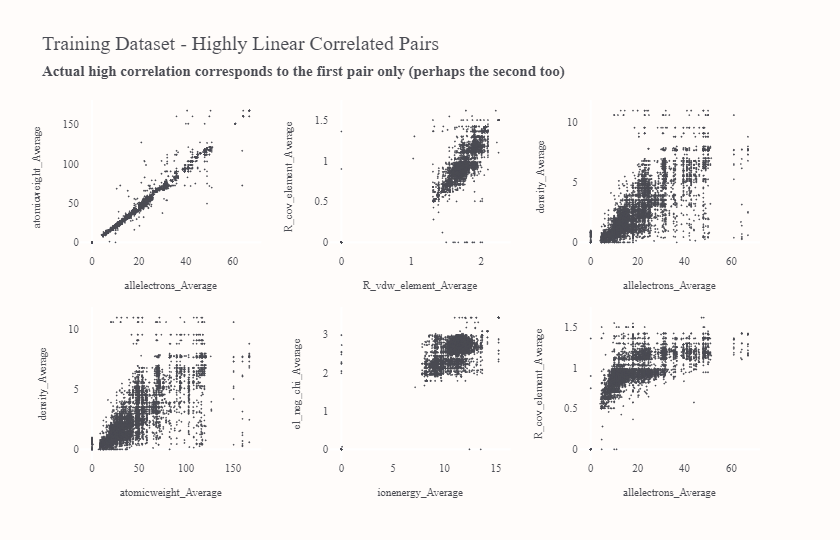

In [18]:
n_cols, n_features = 3, 6
n_rows, axes = get_n_rows_and_axes(n_features, n_cols)

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    horizontal_spacing=0.1,
    vertical_spacing=0.15,
)

for (row, col), (feature1, feature2, corr) in zip(axes, abs_corr[:n_features].to_numpy()):
    fig.add_scatter(
        x=train[feature1],
        y=train[feature2],
        mode="markers",
        name="",
        row=row,
        col=col,
    )
    fig.update_xaxes(title_text=feature1, row=row, col=col)
    fig.update_yaxes(title_text=feature2, row=row, col=col)

fig.update_layout(
    title="Training Dataset - Highly Linear Correlated Pairs<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Actual high correlation corresponds to the first pair only (perhaps the second too)</span>",
    width=840,
    height=540,
    showlegend=False,
)
fig.update_traces(
    marker=dict(size=1, symbol="x-thin", line=dict(width=1.5, color=COLOR_SCHEME[0])),
)
save_and_show_fig(fig, "highly_correlated_scatter_plots")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Highly Linear Correlated Pairs</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    So, as we can see, there is a clearly visible high correlation between <code>allelectrons_Average</code> and <code>atomicweight_Average</code>. On the other hand, it's hard to say something about <code>ionenergy_Average</code> and <code>el_neg_chi_Average</code> because zero-points warp the correlation.
</p>

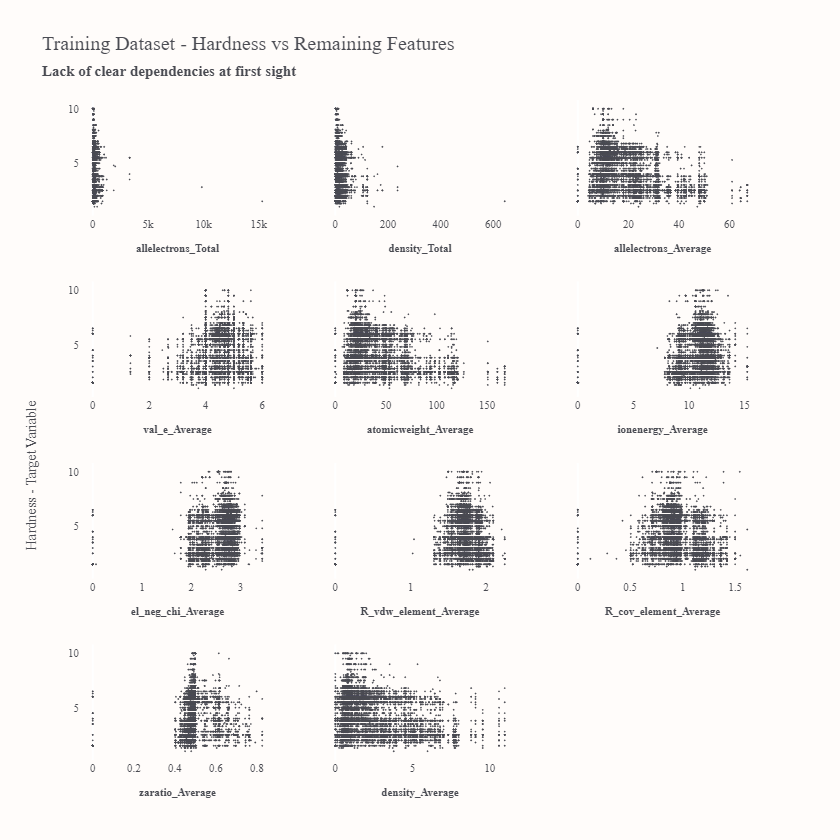

In [19]:
n_cols = 3
n_rows, axes = get_n_rows_and_axes(len(features), n_cols)

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    y_title="Hardness - Target Variable",
    horizontal_spacing=0.07,
    vertical_spacing=0.1,
)
fig.update_annotations(font_size=14, yshift=-45)

for (row, col), feature in zip(axes, features):
    fig.add_scatter(
        x=train[feature],
        y=train.Hardness,
        mode="markers",
        name=feature,
        row=row,
        col=col,
    )
    fig.update_xaxes(
        title_text=f"<b>{feature}</b>",
        row=row,
        col=col,
    )
    if not col == 1:
        fig.update_yaxes(showticklabels=False, row=row, col=col)

fig.update_layout(
    title="Training Dataset - Hardness vs Remaining Features<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Lack of clear dependencies at first sight</span>",
    width=840,
    height=840,
    showlegend=False,
)
fig.update_traces(
    marker=dict(size=1, symbol="x-thin", line=dict(width=1.5, color=COLOR_SCHEME[0])),
)
save_and_show_fig(fig, "scatter_plots")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Scatter Plots</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    So, at first sight, there are no clear dependencies between target variables and the other features. We can say it only for <code>allelectrons_Average</code>, <code>atomicweight_Average</code> and <code>density_Average</code>. In these cases, actually, the negative correlation is visible, but it's not so strong. As for the whole, we can see structurally deployed samples and straight patterns. That's the result of the low diversity of continuous variables and many repetitive values. Probably we can clip outliers in <code>allelectrons_Total</code> and <code>density_Total</code>.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.3</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Probability Plots &amp; Example Transformations</span></b><a class="anchor" id="probability_plots_and_example_transformations"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    This subsection focuses on the exploration of probability plots, which are a graphical technique used to determine if a variable adheres to a particular distribution, specifically the normal distribution in this case. <b>Probability plots display samples that follow a normal distribution along a straight diagonal line.</b> Some machine learning models make the assumption that variables follow a normal distribution. Consequently, the mentioned technique assists in determining the necessary transformations to improve the variable's alignment with that distribution. We will begin with examining the original values and observing the outcomes.
</p>

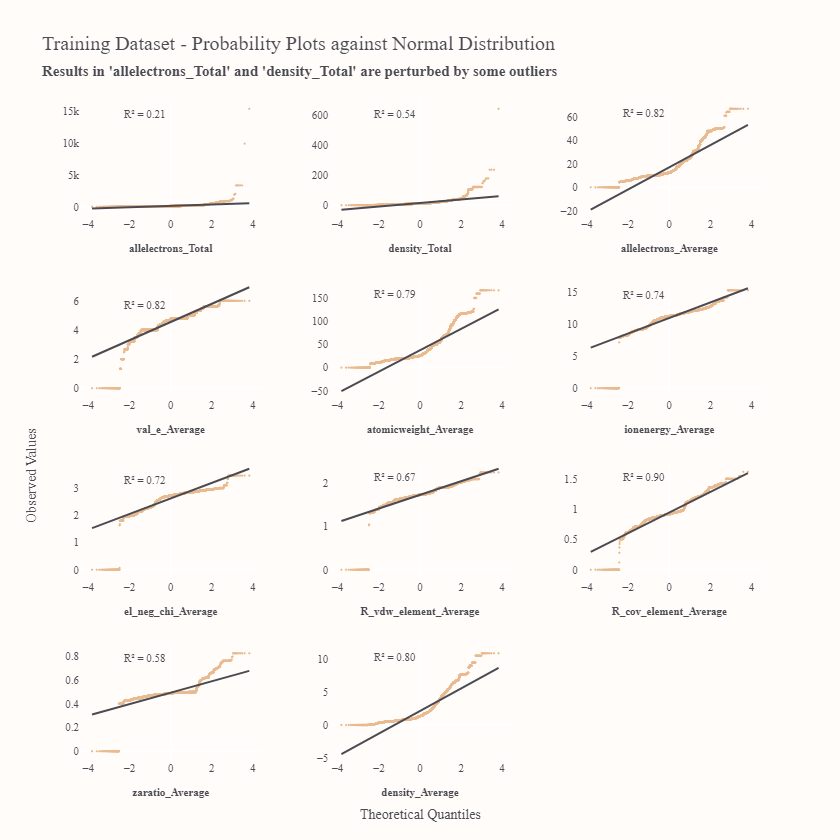

In [20]:
n_cols = 3
n_rows, axes = get_n_rows_and_axes(len(features), n_cols)

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    y_title="Observed Values",
    x_title="Theoretical Quantiles",
    horizontal_spacing=0.1,
    vertical_spacing=0.1,
)
fig.update_annotations(font_size=14, yshift=-45)

for (row, col), feature in zip(axes, features):
    (osm, osr), (slope, intercept, R) = stats.probplot(train[feature].dropna(), rvalue=True)
    x_theory = np.array([osm[0], osm[-1]])
    y_theory = intercept + slope * x_theory
    R2 = f"R\u00b2 = {R * R:.2f}"
    fig.add_scatter(x=osm, y=osr, mode="markers", row=row, col=col, name=feature)
    fig.add_scatter(x=x_theory, y=y_theory, mode="lines", row=row, col=col)
    fig.add_annotation(
        x=-1.25,
        y=osr[-1] * 0.95,
        text=R2,
        showarrow=False,
        row=row,
        col=col,
        font_size=11,
    )
    fig.update_xaxes(
        title_text=f"<b>{feature}</b>",
        row=row,
        col=col,
    )

fig.update_layout(
    title="Training Dataset - Probability Plots against Normal Distribution<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Results in 'allelectrons_Total' and 'density_Total' are perturbed by some outliers</span>",
    width=840,
    height=840,
    showlegend=False,
)
fig.update_traces(
    marker=dict(size=1, symbol="x-thin", line=dict(width=2, color=COLOR_SCHEME[2])),
    line_color=COLOR_SCHEME[0],
)
save_and_show_fig(fig, "probability_plots")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Probability Plots against Normal Distribution</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    As you can see, some variables fit a normal distribution well, which manifests by a high coefficient of determination (R-squared) and evenly deployed samples around the straight line. However, there are same of features which have a poor fit. We can improve that through specific transformations. Mostly used transformations are log-level and square-root ones. These work fine with right-skewed data and help to reduce the impact of outliers. Another transformation is, for example, a reciprocal one, which is sometimes used when data is skewed, or there are obvious outliers. More sophisticated methods are Box-Cox transformation (requires strictly positive numbers) and Yeo-Johnson (variation of Box-Cox), which has no restrictions concerning numbers. We will check three of mentioned: log-level, square-root and Yeo-Johnson. For this case, we will utilise the <code>probplot</code> function from the <code>scipy</code> module to get R-squared coefficients as earlier.
</p>

In [21]:
r2_scores = pd.DataFrame(index=("Original", "YeoJohnson", "Log", "Sqrt"))

for feature in features:
    orig = train[feature].dropna()
    _, (*_, R_orig) = stats.probplot(orig, rvalue=True)
    _, (*_, R_yeojohn) = stats.probplot(stats.yeojohnson(orig)[0], rvalue=True)
    _, (*_, R_log) = stats.probplot(np.log1p(orig), rvalue=True)
    _, (*_, R_sqrt) = stats.probplot(np.sqrt(orig), rvalue=True)

    r2_scores[feature] = (
        R_orig * R_orig,
        R_yeojohn * R_yeojohn,
        R_log * R_log,
        R_sqrt * R_sqrt,
    )

r2_scores = r2_scores.transpose()
r2_scores["Winner"] = r2_scores.idxmax(axis=1)
get_pretty_frame(r2_scores)

,Original,YeoJohnson,Log,Sqrt,Winner
allelectrons_Total,0.215,0.919,0.876,0.770,YeoJohnson
density_Total,0.536,0.979,0.979,0.885,YeoJohnson
allelectrons_Average,0.817,0.921,0.908,0.903,YeoJohnson
val_e_Average,0.816,0.951,0.543,0.562,YeoJohnson
atomicweight_Average,0.795,0.917,0.891,0.896,YeoJohnson
ionenergy_Average,0.737,0.947,0.340,0.448,YeoJohnson
el_neg_chi_Average,0.718,0.926,0.503,0.455,YeoJohnson
R_vdw_element_Average,0.672,0.942,0.465,0.375,YeoJohnson
R_cov_element_Average,0.895,0.914,0.826,0.689,YeoJohnson
zaratio_Average,0.583,0.612,0.535,0.376,YeoJohnson


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>R-squared Scores within Some Transformations</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Well, as you can see <b>Yeo-Johnson's transformation wins in all cases and improves fit to the normal distribution pretty well</b> ($R^2$ scores almost in all cases are above $0.90$). However, there is a one feature where none of the transformations helps, i.e. <code>zaratio_Average</code>. Probably it's the effect of specific shape of this feature (looks like a half-normal distribution). Let's see how Yeo-Johnson transformation helps with specific feature, for example, the <code>density_Total</code> one.
</p>

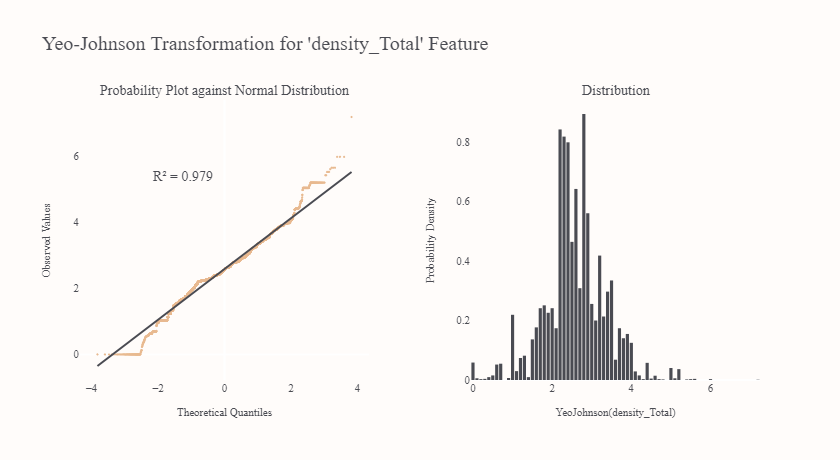

In [22]:
density_Total_transformed = stats.yeojohnson(train.density_Total.dropna())[0]
(osm, osr), (slope, intercept, R) = stats.probplot(density_Total_transformed, rvalue=True)
x_theory = np.array([osm[0], osm[-1]])
y_theory = intercept + slope * x_theory

fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=["Probability Plot against Normal Distribution", "Distribution"],
    horizontal_spacing=0.15,
)

fig.add_scatter(x=osm, y=osr, mode="markers", row=1, col=1, name="YeoJohnson(density_Total)")
fig.add_scatter(x=x_theory, y=y_theory, mode="lines", row=1, col=1)
fig.add_annotation(
    x=-1.25,
    y=osr[-1] * 0.75,
    text=f"R\u00b2 = {R * R:.3f}",
    showarrow=False,
    row=1,
    col=1,
)
fig.update_yaxes(title_text="Observed Values", row=1, col=1)
fig.update_xaxes(title_text="Theoretical Quantiles", row=1, col=1)
fig.update_traces(
    marker=dict(size=1, symbol="x-thin", line=dict(width=2, color=COLOR_SCHEME[2])),
    line_color=COLOR_SCHEME[0],
)

fig.add_histogram(
    x=density_Total_transformed,
    xbins=go.histogram.XBins(size=0.1),
    marker_color=COLOR_SCHEME[0],
    name="YeoJohnson(density_Total)",
    histnorm="probability density",
    row=1,
    col=2,
)
fig.update_yaxes(title_text="Probability Density", row=1, col=2)
fig.update_xaxes(title_text="YeoJohnson(density_Total)", row=1, col=2)

fig.update_layout(
    title="Yeo-Johnson Transformation for 'density_Total' Feature",
    showlegend=False,
    width=840,
    height=460,
    bargap=0.2,
)
fig.update_annotations(font_size=14)
save_and_show_fig(fig, "density_Total_after_transform")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Yeo-Johnson Transformation</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    It looks pretty well. We can include this type of transform in the preprocessing pipeline. Models like SVM and Linear Regression should be grateful.
</p>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Features Importance</span></b><a class="anchor" id="features_importance"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>About Section</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In this section, we will tackle the general problem of features' importance. Generally, sometimes not all variables are crucial during the training process, and only some are relevant for specific models. There are many methods, from selecting some top features based on the ANOVA test, mutual information, up to recursive feature selection with cross-validation. We can also select features from given models like random forest using the importance ratio. Generally, different methods may give different results. Moreover, it's good to include random variables in training data and measure their importance. <b>If some random numbers are more important than given features, it means that those variables are useless (may introduce a noise) from the problem perspective (but still can be useful in other tasks).</b> In this section, we will investigate decision process in a simple decision tree, and the we will focus on gradient boosting trees. We will see permutation tests, random variables, mutual information, one-way partial dependence plots (PDPs) and two-way PDPs.<br><br>
    <b>This section has a showcase character and all what can you see here may be slightly different depending on used machine learning algorithm or random seeds. Nevertheless, it will show us, in general, which features are more important and which are not.</b>
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.1</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Decision Process in Simple Decision Tree</span></b><a class="anchor" id="simple_decision_tree_and_its_decision_process"></a> [↑](#top)

In [23]:
X = train.drop("Hardness", axis=1)
y = train.Hardness

DefaultDecisionTreeRegressor = partial(
    DecisionTreeRegressor,
    criterion="absolute_error",  # Watch out on learning time complexity.
    random_state=42,
    max_depth=3,
)

tree = DefaultDecisionTreeRegressor().fit(X, y)

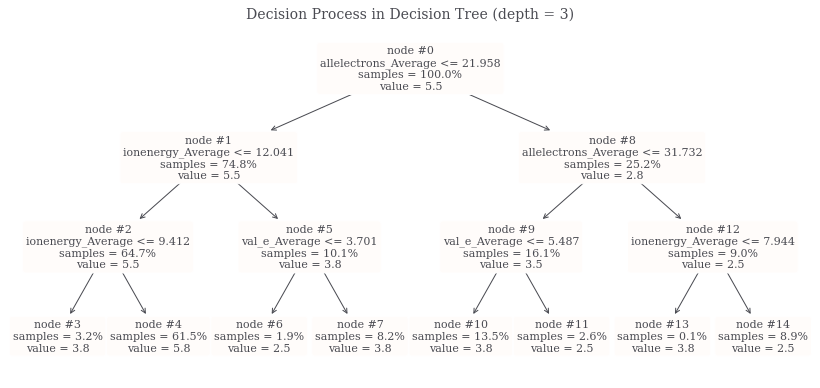

In [24]:
plt.figure(figsize=(11.5, 5.5), tight_layout=True)
plot_tree(
    decision_tree=tree,
    feature_names=tree.feature_names_in_.tolist(),
    filled=False,
    rounded=True,
    impurity=False,
    proportion=True,
    node_ids=True,
    ax=plt.gca(),
    fontsize=11,
)
plt.title("Decision Process in Decision Tree (depth = 3)")
plt.savefig("images/decision_process_in_tree")
plt.show()

In [25]:
for depth in range(2, 7):
    tree.set_params(max_depth=depth).fit(X, y)
    considered_features = tree.tree_.feature[tree.tree_.feature != -2]  # type: ignore # -2 means a leaf
    used_features = np.unique(considered_features)
    used_features = X.columns[used_features].to_list()
    print(CLR + f"Features at depth {depth}: {RED}{len(used_features):<5}", end="")
    tree_cv_results = -cross_val_score(
        estimator=tree,
        X=X,
        y=y,
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        scoring="neg_median_absolute_error",
        n_jobs=2,
    )
    mean, std = tree_cv_results.mean(), tree_cv_results.std()
    print(CLR + "MedAE:", RED + f"{mean:.2f} \u00b1 {std:.2f}")

Features at depth 2: 2    MedAE: 0.66 ± 0.08
Features at depth 3: 3    MedAE: 0.50 ± 0.00
Features at depth 4: 8    MedAE: 0.50 ± 0.00
Features at depth 5: 10   MedAE: 0.50 ± 0.00
Features at depth 6: 11   MedAE: 0.50 ± 0.00


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Decision Process in Tree</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    So, we've got here a simple, default decision tree within a depth of $3$. I used such a depth to easily show you nodes. Subsequently, I performed cross-validation to assess how depth influences the outcome, and it turns out that we get the same output as the depth is equal to $3$ or more. So, three features are enough to get MedAE $= 0.5$. Is that decent? Probably not. Moreover, note that number of considered features at depth $4$ increases from $3$ to $8$, compared to depth $3$. 
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.2</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Random Variables &amp; Permutation Test</span></b><a class="anchor" id="random_variables_permutation_test"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Here, we're going to start by introducing random variables to the dataset. Why? Well, when you introduce random variables to the dataset and train the model, you may check feature importances, for example, based on reduction in MAE criterion. <b>When a random variable contributes to the reduction of MAE more than the specific feature available in the dataset, it means that this feature is a noise indeed from the task perspective.</b>
</p>

In [26]:
DefaultLGBMRegressor = partial(
    LGBMRegressor,
    objective="regression_l1",
    random_state=42,
    verbose=-1,
)

In [27]:
np.random.seed(42)
seeds = np.random.randint(0, 19937, size=5)

X = train.drop("Hardness", axis=1)
y = train.Hardness

lgbm = DefaultLGBMRegressor()
importances = []

for seed in seeds:
    np.random.seed(seed)
    X["RANDOM_1"] = np.random.normal(size=len(X))
    X["RANDOM_2"] = np.random.normal(size=len(X))
    X["RANDOM_3"] = np.random.normal(size=len(X))
    X["RANDOM_4"] = np.random.normal(size=len(X))
    X["RANDOM_5"] = np.random.normal(size=len(X))

    lgbm.set_params(random_state=seed).fit(X, y)
    importances.append(unit_norm(lgbm.feature_importances_))

importances = (
    pd.DataFrame({"Feature": X.columns, "Importance": np.array(importances).mean(axis=0)})
    .sort_values(by="Importance", ascending=False)
    .reset_index(drop=True)
)

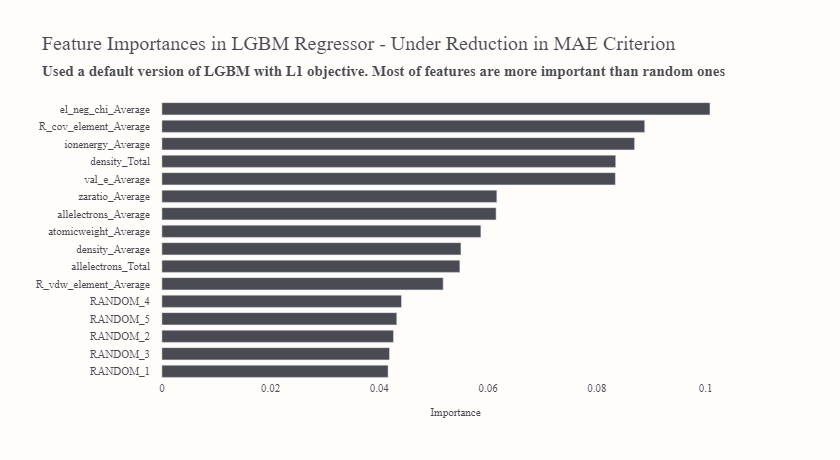

In [28]:
fig = px.bar(
    importances,
    x="Importance",
    y="Feature",
    height=460,
    width=840,
    title="Feature Importances in LGBM Regressor - Under Reduction in MAE Criterion<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Used a default version of LGBM with L1 objective. "
    "Most of features are more important than random ones</span>",
)
fig.update_yaxes(categoryorder="total ascending", title="")
fig.update_xaxes(range=(-0.002, 0.11))
fig.update_traces(width=0.7)
save_and_show_fig(fig, "importance_with_mae_reduction")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Feature Importances via Reduction in MAE</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Here I used $5$ different seeds to gain more reliable results. <b>As we can see, in this specific situation, most of variables are more important than random ones.</b> However, some of them are at the randomness level. What is more, if we had defined only one random feature, it could turn out that we've been just lucky that it's essential or not. We have a more general recognition when we define several of them.
</p>

In [29]:
np.random.seed(42)
seeds = np.random.randint(0, 19937, size=5)

lgbm = DefaultLGBMRegressor()
permutation_medae = defaultdict(list)

for seed in seeds:
    np.random.seed(seed)
    X["RANDOM_1"] = np.random.normal(size=len(X))
    X["RANDOM_2"] = np.random.normal(size=len(X))
    X["RANDOM_3"] = np.random.normal(size=len(X))
    X["RANDOM_4"] = np.random.normal(size=len(X))
    X["RANDOM_5"] = np.random.normal(size=len(X))

    kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
    lgbm.set_params(random_state=seed)

    for k, (train_ids, valid_ids) in enumerate(kfold.split(X, y)):
        X_train, y_train = X.iloc[train_ids], y[train_ids]  # type: ignore
        X_valid, y_valid = X.iloc[valid_ids], y[valid_ids]  # type: ignore

        lgbm.fit(X_train, y_train)
        medae = median_absolute_error(y_valid, lgbm.predict(X_valid))  # type: ignore

        for i, feature in enumerate(X_train.columns):
            X_shuffled = X_valid.copy()
            X_shuffled.iloc[:, i] = np.random.permutation(X_shuffled.iloc[:, i])
            medae_shuffled = median_absolute_error(y_valid, lgbm.predict(X_shuffled))  # type: ignore
            # I assume an increase in MedAE if the attribute is essential.
            permutation_medae[feature].append(((medae_shuffled - medae) / medae) * 100.0)

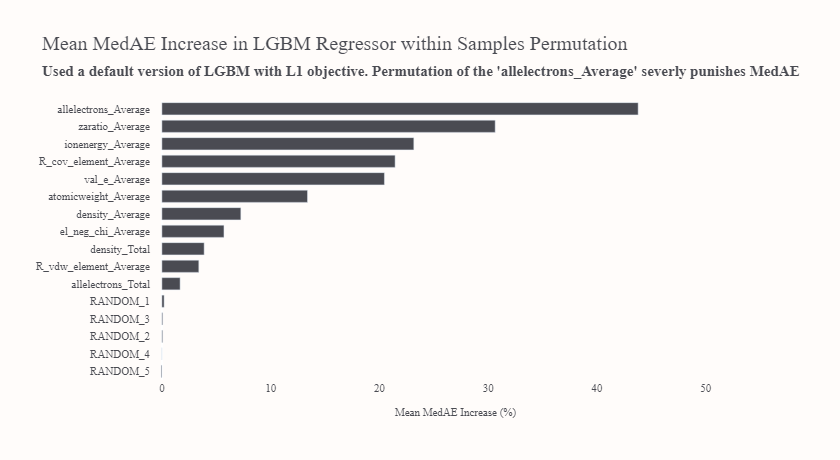

In [30]:
medae_increase = (
    pd.DataFrame(permutation_medae)
    .mean()
    .sort_values(ascending=False)
    .to_frame(name="Mean MedAE Increase (%)")
    .reset_index(names="Feature")
)

fig = px.bar(
    medae_increase,
    x="Mean MedAE Increase (%)",
    y="Feature",
    height=460,
    width=840,
    title="Mean MedAE Increase in LGBM Regressor within Samples Permutation<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Used a default version of LGBM with L1 objective. "
    "Permutation of the 'allelectrons_Average' severly punishes MedAE</span>",
)
fig.update_yaxes(categoryorder="total ascending", title="")
fig.update_xaxes(range=(-1, 55))
fig.update_traces(width=0.7)
save_and_show_fig(fig, "importance_with_feature_permutation")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Samples Permutation Test</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In the code above, we explore how rearranging samples within a specific feature affects MedAE when evaluating the validation dataset. To ensure more reliable outcomes, this entire process is repeated with different random seeds. Importantly, throughout this entire process, we shuffle samples in the chosen feature of the validation subset and record results obtained from evaluating this modified dataset in a separate dictionary. If the variable is significant, we should observe worsened results in terms of MedAE. <b>As we can see, some features punish the model mostly. But it doesn't concern random variables.</b> For <code>density_Total</code>, <code>density_Average</code>, and <code>allelectrons_Total</code> variables the situation is similar to random features.<br><br>
    Everything I show here is only illustrative, and the aim is to gain a little intuition about available features. Different models can recognise various features as relevant ones. Moreover, when you set a certain depth or minimum number of samples in a leaf in the tested gradient boosting regressor, you probably get a slightly different outcome. 
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.3</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Mutual Information</span></b><a class="anchor" id="mutual_information"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Let's check feature importance via the mutual information method. Generally, mutual information is a quantity that measures the relation between simultaneously sampled variables. In other words, it measures how much information about one variable is, on average, enclosed in the second variable. Intuitively, we can ask how much one variable tells us about the second one. <b>The theorem says that the mutual information between two variables is zero if and only if these are statistically independent.</b>
</p>

In [31]:
np.random.seed(42)
seeds = np.random.randint(0, 19937, size=5)

scaler = StandardScaler()
mutual_info = []

for seed in seeds:
    np.random.seed(seed)
    X["RANDOM_1"] = np.random.normal(size=len(X))
    X["RANDOM_2"] = np.random.normal(size=len(X))
    X["RANDOM_3"] = np.random.normal(size=len(X))
    X["RANDOM_4"] = np.random.normal(size=len(X))
    X["RANDOM_5"] = np.random.normal(size=len(X))

    # Choose of neighbors is subjective.
    mi = mutual_info_regression(X=scaler.fit_transform(X), y=y, n_neighbors=50, random_state=seed)
    mutual_info.append(mi)

mi_importances = (
    pd.DataFrame({"Feature": X.columns, "Mutual Information": np.array(mutual_info).mean(axis=0)})
    .sort_values(by="Mutual Information", ascending=False)
    .reset_index(drop=True)
)

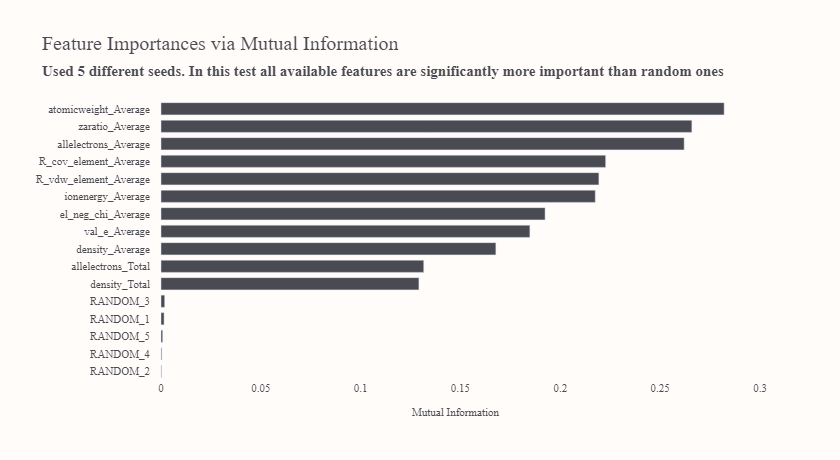

In [32]:
fig = px.bar(
    mi_importances,
    x="Mutual Information",
    y="Feature",
    height=460,
    width=840,
    title="Feature Importances via Mutual Information<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Used 5 different seeds. In this test all available features "
    "are significantly more important than random ones</span>",
)
fig.update_yaxes(categoryorder="total ascending", title="")
fig.update_xaxes(range=(-0.005, 0.3))
fig.update_traces(width=0.7)
save_and_show_fig(fig, "mutual_information")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Mutual Information Results</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    As we can see, mutual information says that all features are more important than randome variables. Therefore, this is a slightly different outcome than in tests with random forest. Let's get to something more interesting, i.e. partial dependence plots.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.4</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Partial Dependence for Features of Interest</span></b><a class="anchor" id="partial_dependence_for_features_of_interest"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Generally, a partial dependence plot (PDP) is another tool for visualizing feature importance. However, this approach differs slightly from the earlier depicted. <b>Here, the partial dependence plot shows the relationship between the model outcome and a particular feature or a set of particular features.</b> In this case, the outcome (partial dependence) is an output of the <code>predict()</code> method. So, it's just a prediction for the <code>Hardness</code> variable. In other words, according to <code>scikit-learn</code> docs: <i>Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest.</i> Let's have a look at how it works and how it looks.
</p>

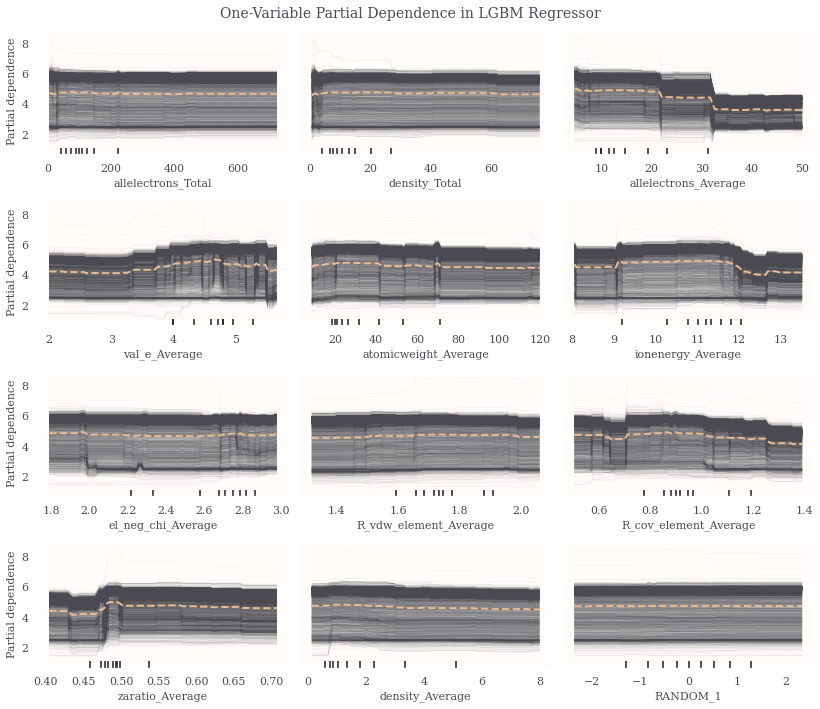

In [33]:
np.random.seed(42)

X = train.drop("Hardness", axis=1).assign(RANDOM_1=np.random.normal(size=len(train)))
y = train.Hardness

lgbm = DefaultLGBMRegressor().fit(X, y)

fig, axes = plt.subplots(4, 3, figsize=(11.5, 10), tight_layout=True, sharey=True)
plt.suptitle("One-Variable Partial Dependence in LGBM Regressor")
PartialDependenceDisplay.from_estimator(
    estimator=lgbm,  # type: ignore
    X=X,
    features=X.columns.tolist(),
    feature_names=X.columns.tolist(),
    response_method="auto",  # In regression, the response is `predict()` output.
    kind="both",  # PDP and ICE.
    percentiles=(0.01, 0.99),
    subsample=0.5,
    random_state=42,
    n_jobs=-1,
    ice_lines_kw={"color": COLOR_SCHEME[0], "linewidth": 0.2, "alpha": 0.1, "linestyle": "--"},
    pd_line_kw={"color": COLOR_SCHEME[2], "linewidth": 2.0},
    ax=axes.ravel(),  # type: ignore
)

for ax in axes.ravel():
    ax.get_legend().remove()
    if ax not in (axes[0, 0], axes[1, 0], axes[2, 0], axes[3, 0]):
        ax.set_ylabel("")

plt.savefig("images/one_way_partial_dependence")
plt.show()

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Partial Dependence</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Here we have PDP visualizations all features of interest. I included one random variable to show you how looks a feature that does not drive any influence.This way, we can see how different features impact the model, whether it's a linear dependence or not. What is more, one needs to add something. <b>Actually, we've created PDP and individual conditional expectation (ICE) plots. ICE is similar to PDP, but here, the ICE plot shows the dependency of the prediction within a given feature for each sample (it means each black line corresponds to a specific sample).</b><br><br>
    Well, so what do we see here? I describe it using the <code>ionenergy_Average</code> feature of interest. Firstly, we need to remember that interactions between features are not included here. It means that we see predictions of the model (partial dependence) depending on only one feature. Concerning the <code>ionenergy_Average</code> variable, we can see that initially the output is constant as the feature grows, i.e. the dependence is constant in the range $(8, 9)$ of <code>ionenergy_Average</code>. On a higher cut-off, the <code>ionenergy_Average</code> starts to drive an influence on the model, i.e., in the range $~9.0$ the dependence is positive and (probably?) non-linear. Next, in the range $(9, 12.0)$ it's a constant again, and subsequently has a negative impact. <b>So there are narrow ranges of this feature where the outcome rapidly grows or drops.</b><br><br>
    Now let's have a look at random variable. The dependence is always constant here, which means that this feature doesn't introduce any information. Now let's have a look at PDP with two input features of interest. That will show us interactions.
</p>

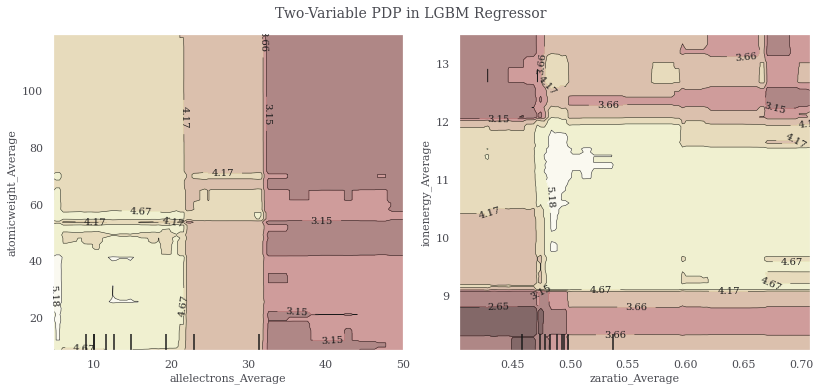

In [34]:
interaction_pair1 = ["allelectrons_Average", "atomicweight_Average"]
interaction_pair2 = ["zaratio_Average", "ionenergy_Average"]

X = train[np.union1d(interaction_pair1, interaction_pair2)]
y = train.Hardness
lgbm = DefaultLGBMRegressor().fit(X, y)  # type: ignore

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11.5, 5.5), tight_layout=True)
plt.suptitle("Two-Variable PDP in LGBM Regressor")
PartialDependenceDisplay.from_estimator(
    estimator=lgbm,  # type: ignore
    X=X,
    features=[interaction_pair1, interaction_pair2],
    feature_names=X.columns.to_list(),
    response_method="auto",  # In regression, the response is `predict()` output.
    percentiles=(0.01, 0.99),
    random_state=42,
    n_jobs=-1,
    contour_kw={"cmap": "pink"},
    ax=axes,  # type: ignore
)

plt.savefig("images/two_way_partial_dependence")
plt.show()

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Interactions</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The two-variable PDP above shows the dependence of the target variable on joint values of two pairs, i.e. (<code>allelectrons_Average</code>, <code>atomicweight_Average</code>) and (<code>zaratio_Average</code>, <code>ionenergy_Average</code>). Here, for example, we can see that if the <code>zaratio_Average</code> is greater than $0.5$, the main impact on prediction has <code>ionenergy_Average</code>, but when <code>zaratio_Average</code> is in the range $(0.45, 0.50)$, the situation is diversed.
</p>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">3</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Dimensionality Reduction</span></b><a class="anchor" id="dimensionality_reduction"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    There we have several interesting dimensionality reduction algorithms, like t-SNE, PCA or LLE. For example the t-SNE method is a great reduction technique commonly used for visualizing complex and high-dimensional data in a lower-dimensional space. Moreover, it tries to preserve the original structure of data, so similar samples should be deployed close to each other in reduced dimensions. Using t-SNE we should provide scaled data, otherwise, certain dimensions can be dominated by features with larger scales or units. For the purpose of this notebook, we can test two techniques, i.e. PCA, Isomap and t-SNE.
</p>

In [35]:
X = train.drop("Hardness", axis=1)
y = train.Hardness

transformer = PowerTransformer(method="yeo-johnson", standardize=True)
X_rescaled = transformer.fit_transform(X)

pca_2d = PCA(n_components=2, random_state=42)
iso_2d = Isomap(n_components=2, n_neighbors=20, n_jobs=-1)
tsne_2d = TSNE(n_components=2, random_state=42, n_jobs=-1)

pca_2d_results = pd.DataFrame(pca_2d.fit_transform(X_rescaled), columns=("x1", "x2")).join(y)
iso_2d_results = pd.DataFrame(iso_2d.fit_transform(X_rescaled), columns=("x1", "x2")).join(y)
tsne_2d_results = pd.DataFrame(tsne_2d.fit_transform(X_rescaled), columns=("x1", "x2")).join(y)

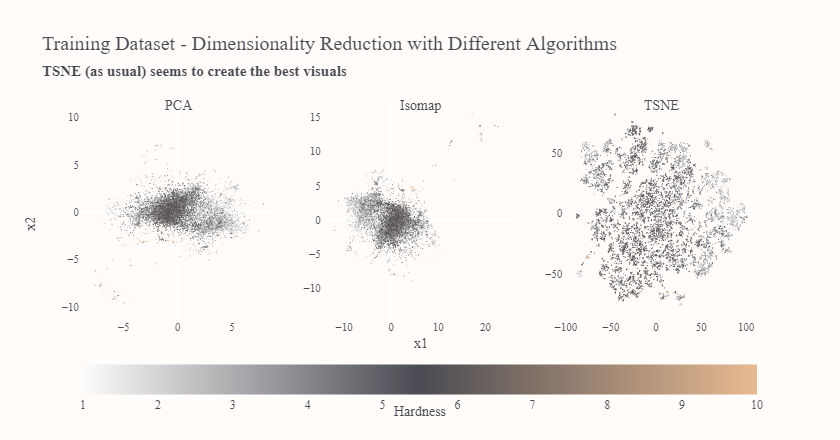

In [36]:
n_cols, n_projections = 3, 3
n_rows, axes = get_n_rows_and_axes(n_projections, n_cols)
fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    subplot_titles=("PCA", "Isomap", "TSNE"),
    x_title="x1",
    y_title="x2",
    # horizontal_spacing=0.1,
    vertical_spacing=0.1,
)

for (row, col), projection in zip(axes, (pca_2d_results, iso_2d_results, tsne_2d_results)):
    fig.add_scatter(
        x=projection.x1,
        y=projection.x2,
        mode="markers",
        marker=dict(size=1, color=projection.Hardness, coloraxis="coloraxis"),
        row=row,
        col=col,
        showlegend=False,
    )

fig.update_annotations(font_size=14, yshift=-15)
fig.update_coloraxes(
    colorbar=dict(
        title_text="Hardness",
        ticklabelposition="outside bottom",
        orientation="h",
        title_side="bottom",
        yanchor="bottom",
        xanchor="center",
        len=1.02,
        y=-0.5,
        x=0.5,
    ),
    colorscale=colormap,
)
fig.update_layout(
    title="Training Dataset - Dimensionality Reduction with Different Algorithms<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "TSNE (as usual) seems to create the best visuals</span>",
    width=840,
    height=440,
)
save_and_show_fig(fig, "projections_2d")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Dimensionality Reduction Results</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    As we can see, PCA and Isomap produce kind similar outcomes. On the other hand, t-SNE creates a pretty cool low-dimensional visual. Let's get one step further and use t-SNE to create a 3D projection.
</p>

In [37]:
tsne_3d = TSNE(n_components=3, random_state=42, n_jobs=-1)
tsne_3d_results = pd.DataFrame(tsne_3d.fit_transform(X_rescaled), columns=("x1", "x2", "x3")).join(y)

fig = px.scatter_3d(
    tsne_3d_results,
    x="x1",
    y="x2",
    z="x3",
    color="Hardness",
    color_continuous_scale=colormap,
    opacity=0.5,
    height=840,
    width=840,
    title="Training Dataset - 3D Projection with t-SNE<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Many samples overlap but these with low 'Hardness' seems to "
    "be separated pretty well</span>",
)
fig.update_traces(marker_size=2)
fig.update_coloraxes(colorbar=dict(ticklabelposition="outside bottom"))
fig.show()

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Dimensionality Reduction with t-SNE</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    So, here we see that t-SNE tried to separate samples with different <code>Hardness</code> value levels. For example, there is an area that is dominated by samples with low <code>Hardness</code>. Well, dimensionality reduction is a nice tool but in this specific problem samples seems to be difficult to separate them clearly.
</p>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">4</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Outliers Detection</span></b><a class="anchor" id="outliers_detection"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Generally, there are several methods available in the <code>scikit-learn</code> library if you ask for the outlier detector, such as <code>SGDOneClassSVM</code>, which is a linear model, <code>LocalOutlierFactor</code>, which is based on nearest neighbours, and <code>IsolationForest</code> based on bagging trees. We will focus on the <code>LocalOutlierFactor</code>, but I provide a code that you can easily modify to change a detector.<br><br>
    Okay, so how do we assess whether removing outliers will probably work for the test dataset? Well, let's cross-validate it. The point is that we carry on typical cross-validation, but in addition to train the model on the training subset, we train it again on the "clean" training subset, where "clean" means a subset without outliers. Subsequently, we collect results obtained for validation subsets for two types of models. This trained on full training subset and that trained on clean subset. Suppose we observe a reduction in terms of a given metric for the validation subset in all folds. In that case, that's probably a good method of removing outliers. And here is a crucial point. We should observe a reduction in all folds. <b>When we observe a reduction in some folds but not in others, we rather should not remove outliers because the test dataset can resemble that one fold when removing outliers came with lower model performance.</b>
</p>

In [38]:
def remove_outliers(data, detector):
    if not isinstance(data, pd.DataFrame):
        raise TypeError(f"'data' must be {pd.DataFrame!r} instance")

    result = detector.fit_predict(data)
    outlier_ids = pd.Series(result == -1, index=data.index, dtype=bool)
    data_ids = pd.Series(np.ones_like(data.index), index=data.index, dtype=bool)
    
    return data[~(outlier_ids & data_ids)]

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Removing Outliers</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Since outlier detectors in <code>scikit-learn</code> predict $-1$ for the outlier sample, we create a mask and return the dataset without associated observations in the <code>remove_outliers()</code> function. Subsequently, below I create simple LGBM model which implements MAE loss pretty well compared to previously used random forests, and perform CV scheme I described earlier.
</p>

In [39]:
lgbm = DefaultLGBMRegressor()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
detector = make_pipeline(
    PowerTransformer(method="yeo-johnson", standardize=True),
    LocalOutlierFactor(),
)

hyperparameter = "localoutlierfactor__contamination"
hyperparameter_values = [None] + np.arange(0.01, 0.15, 0.01).tolist()
no_outliers_medae = {}

for k, (train_ids, valid_ids) in enumerate(kfold.split(X, y), start=1):
    X_train, y_train = X.iloc[train_ids], y.iloc[train_ids]
    X_valid, y_valid = X.iloc[valid_ids], y.iloc[valid_ids]

    lgbm.fit(X_train, y_train)
    default_medae = median_absolute_error(y_valid, lgbm.predict(X_valid))  # type:ignore

    for hp_value in hyperparameter_values:
        if hp_value is None:
            no_outliers_medae[f"0 - {k}"] = default_medae
            continue

        detector.set_params(**{hyperparameter: hp_value})
        X_no_outliers = remove_outliers(X_train, detector)
        y_no_outliers = y_train[X_no_outliers.index]

        lgbm.fit(X_no_outliers, y_no_outliers)
        clean_medae = median_absolute_error(y_valid, lgbm.predict(X_valid))  # type:ignore
        no_outliers_medae[f"{hp_value} - {k}"] = clean_medae

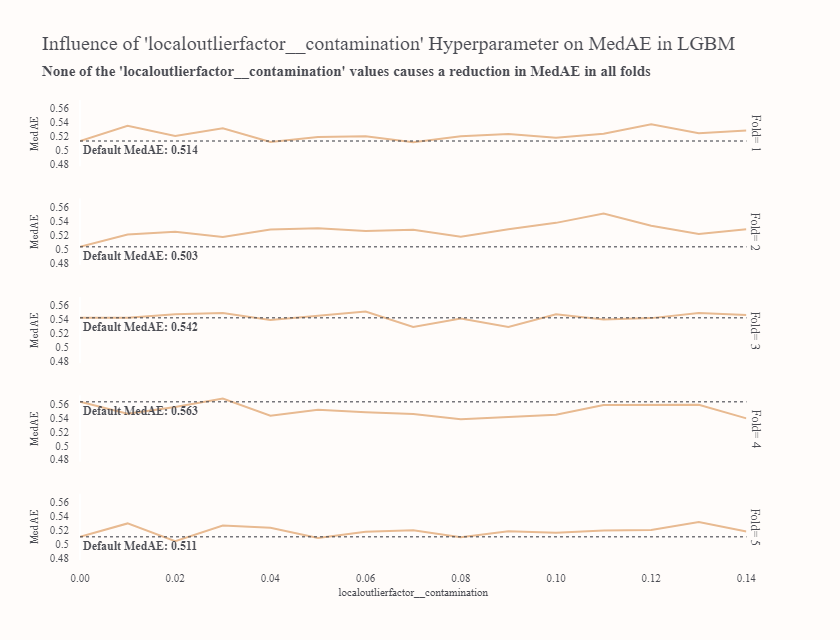

In [40]:
detector_medae = pd.DataFrame({"KEY": no_outliers_medae.keys(), "MedAE": no_outliers_medae.values()})
detector_medae[[hyperparameter, "Fold"]] = detector_medae.KEY.str.split("-", expand=True)
default_medae = detector_medae[detector_medae[hyperparameter].astype(float) == 0].MedAE

fig = px.line(
    detector_medae,
    x=hyperparameter,
    y="MedAE",
    facet_row="Fold",
    facet_row_spacing=0.07,
    color_discrete_sequence=COLOR_SCHEME[2:],
    height=640,
    width=840,
    title=f"Influence of '{hyperparameter}' Hyperparameter on MedAE in LGBM<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    f"None of the '{hyperparameter}' values causes "
    "a reduction in MedAE in all folds</span>",
)
for fold, fold_default_medae in enumerate(default_medae):
    fig.add_hline(
        fold_default_medae,
        annotation_text=f"<b>Default MedAE: {fold_default_medae:.3f}</b>",
        annotation_position="bottom left",
        annotation_font_size=12,
        line_width=1.5,
        opacity=0.75,
        line_dash="dot",
        line_color=COLOR_SCHEME[0],
        row=len(default_medae) - fold,  # type:ignore
    )
fig.update_traces(line_width=2)
fig.update_layout(margin_pad=10)
fig.update_xaxes(tickformat=".2f", type="linear")
save_and_show_fig(fig, "outlier_detection")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Removing Outliers vs Performance</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Unfortunately, removing outliers didn't reduce MedAE in all folds for any of the <code>contamination</code> values in the <code>LocalOutlierFactor</code> detector. I also checked <code>IsolationForest</code> and <code>SGDOneClassSVM</code> with several hyperparameter combinations, but the result is similar. Of course, the whole process depends on model combination. Perhaps this method works for other regressor, rather than LGBM.
</p>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">5</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Modelling</span></b><a class="anchor" id="modelling"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In this section, I'm going to try different approaches to this competition.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">5.1</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Regression Approach</span></b><a class="anchor" id="regression_approach"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Let's get started with a typical approach, i.e. a regression problem. Below, you can see several preprocessing steps.
</p>

In [41]:
def clip_numeric_feature(X, lower_bound=None, upper_bound=None):
    X = np.array(X, copy=False)
    return np.clip(X[:, [0]], lower_bound, upper_bound)


def features_interaction(X, op="mul", eps=1e-9):
    ops = {
        "mul": operator.mul,
        "truediv": operator.truediv,
        "add": operator.add,
        "sub": operator.sub,
    }
    X = np.array(X, copy=False)
    return ops.get(op, operator.mul)(X[:, [0]], X[:, [1]] + eps)


def interaction_name(function_transformer, feature_names_in, name):
    return [name]  # feature names out

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Preprocessing Functions</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    There, we have some simple functions. The first one just clips a numeric feature to given bounds. The second one adds an interaction between two features.  
</p>

In [42]:
preprocessing = make_pipeline(
    make_column_transformer(
        (
            FunctionTransformer(
                features_interaction,
                feature_names_out=partial(
                    interaction_name, name="allelectrons_atomicweight_avg_mul"
                ),
                kw_args=dict(op="mul"),
            ),
            ["allelectrons_Average", "atomicweight_Average"],
        ),
        (
            FunctionTransformer(
                clip_numeric_feature,
                feature_names_out="one-to-one",
                kw_args=dict(lower_bound=0, upper_bound=1894),
            ),
            ["allelectrons_Total"],
        ),
        (
            FunctionTransformer(
                clip_numeric_feature,
                feature_names_out="one-to-one",
                kw_args=dict(lower_bound=0, upper_bound=236),
            ),
            ["density_Total"],
        ),
        remainder="passthrough",
        verbose_feature_names_out=True,
    ),
    PowerTransformer(method="yeo-johnson", standardize=True),
    # FeatureAgglomeration(n_clusters=3, linkage="complete"),
)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Preprocessing Pipeline</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Here, we have a simple preprocessing pipeline that clips some features with outliers we saw earlier and adds a multiplication of the highest correlated pair.
</p>

In [43]:
class FeatureFromModel(
    MetaEstimatorMixin,  # Accepts any regressor
    BaseEstimator,  # `set_params()` and `get_params()`
    TransformerMixin,  # `fit_transform()`
    ClassNamePrefixFeaturesOutMixin,  # `get_feature_names_out()`
):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y):
        check_array(X)
        self.estimator_ = clone(self.estimator).fit(X, y)
        self.n_features_in_ = self.estimator_.n_features_in_
        self._n_features_out = y.ndim
        if hasattr(self.estimator, "feature_names_in_"):
            self.feature_names_in_ = self.estimator.feature_names_in_
        return self

    def transform(self, X):
        check_is_fitted(self)
        check_array(X)
        y_pred = self.estimator_.predict(X)
        if y_pred.ndim == 1:
            return y_pred.reshape(-1, 1)
        return y_pred

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Feature From Model</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    <code>FeatureFromModel</code> estimator will add a new feature from KNN, which should reflect Mohs hardness of nearest samples.
</p>

In [44]:
def round_to_nearest(y, known_values=None, top_n=20):
    if known_values is None:
        known_values = y.value_counts().index.to_numpy()[:top_n]
    y_repeated = np.tile(y, reps=(len(known_values), 1)).transpose()
    lowest_diff_ids = np.abs(y_repeated - known_values).argmin(axis=1)
    return known_values[lowest_diff_ids]

In [45]:
X = train.drop("Hardness", axis=1)
y = train.Hardness
y_oof = np.zeros_like(y)

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
knn = make_pipeline(
    FeatureFromModel(KNeighborsRegressor(n_neighbors=100)),
    MinMaxScaler(),
)
lgb = LGBMRegressor(
    objective="regression_l1",
    min_child_samples=100,
    reg_alpha=20,
    reg_lambda=20,
    verbose=-1,
)

for fold, (train_ids, valid_ids) in enumerate(kfold.split(X, y), start=1):
    X_train, y_train = X.iloc[train_ids], y.iloc[train_ids]
    X_valid, y_valid = X.iloc[valid_ids], y.iloc[valid_ids]

    X_train = preprocessing.fit_transform(X_train)
    X_valid = preprocessing.transform(X_valid)

    X_train = np.c_[X_train, knn.fit_transform(X_train, round_to_nearest(y_train, top_n=10))]
    X_valid = np.c_[X_valid, knn.transform(X_valid)]

    lgb.fit(X_train, round_to_nearest(y_train, top_n=30))
    y_pred = lgb.predict(X_valid).round(2)  # type: ignore
    y_oof[valid_ids] = y_pred
    medae = median_absolute_error(y_valid, y_pred)  # type: ignore

    print(CLR + f"Fold: {fold:2d}", CLR + "- MedAE:", RED + f"{medae:.3f}")

Fold:  1 - MedAE: 0.500
Fold:  2 - MedAE: 0.510
Fold:  3 - MedAE: 0.500
Fold:  4 - MedAE: 0.510
Fold:  5 - MedAE: 0.530
Fold:  6 - MedAE: 0.510
Fold:  7 - MedAE: 0.600
Fold:  8 - MedAE: 0.530
Fold:  9 - MedAE: 0.500
Fold: 10 - MedAE: 0.500


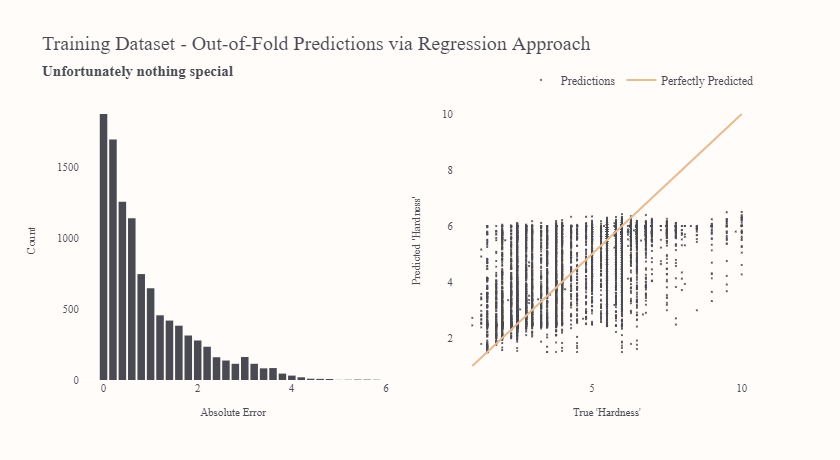

In [46]:
fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.1)

fig.add_histogram(
    x=np.abs(y - y_oof),
    xbins=go.histogram.XBins(size=0.2),
    showlegend=False,
    row=1,
    col=1,
)
fig.update_xaxes(title="Absolute Error", range=(-0.5, 6), row=1, col=1)
fig.update_yaxes(title="Count", row=1, col=1)
fig.add_scatter(
    x=y,
    y=y_oof,
    mode="markers",
    showlegend=True,
    name="Predictions",
    marker=dict(symbol="x", size=2, color=COLOR_SCHEME[0]),
    row=1,
    col=2,
)
fig.add_scatter(x=[1, 10], y=[1, 10], name="Perfectly Predicted", mode="lines", row=1, col=2)
fig.update_yaxes(title="Predicted 'Hardness'", row=1, col=2)
fig.update_xaxes(title="True 'Hardness'", row=1, col=2)
fig.update_layout(
    title="Training Dataset - Out-of-Fold Predictions via Regression Approach<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Unfortunately nothing special</span>",
    height=460,
    width=840,
    bargap=0.2,
    legend=dict(y=1.02, x=1),
)
save_and_show_fig(fig, "out_of_fold_preds_reg")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Simple LGBM Model CV</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In the code above, I decided to reject some unique values of the target variable (we do this only for training subset). Subsequently, I perform a typical CV. As you can see, all of this is completely useless because we got better results with the decision tree with depth $3$. Thank you, MedAE...
</p>

In [47]:
y_train = train.Hardness
X_train = preprocessing.fit_transform(train.drop("Hardness", axis=1))
X_train = np.c_[X_train, knn.fit_transform(X_train, round_to_nearest(y_train, top_n=10))]

X_test = preprocessing.transform(test)
X_test = np.c_[X_test, knn.transform(X_test)]

lgb.fit(X_train, round_to_nearest(y_train, top_n=30))

submission = pd.DataFrame(
    {
        "id": test.index,
        "Hardness": lgb.predict(X_test).round(2),  # type:ignore
    }
).set_index("id")

submission.to_csv("submission_reg.csv")
get_pretty_frame(submission.head(), precision=2)

,Hardness
id,
10407,2.50
10408,2.65
10409,6.00
10410,4.43
10411,4.90


## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">5.2</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Multiclass Classification Approach</span></b><a class="anchor" id="multiclass_classification_approach"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    A couple of days ago, the user <a href="https://www.kaggle.com/fabienpv">FabienPv</a> posted an interesting finding. See here: <a href="https://www.kaggle.com/competitions/playground-series-s3e25/discussion/457631">Interesting fact about data categorization</a>. Namely, we will treat this competition as a multiclass classification problem with categories provided in the post above.
</p>

In [48]:
X = train.drop("Hardness", axis=1)
y = train.Hardness
y_oof = np.zeros_like(y)

cats = np.array((1.75, 2.55, 3.75, 4.75, 5.75, 6.55, 7.75, 8.75, 9.75))
encoder = LabelEncoder()
rskf_cats = encoder.fit_transform(round_to_nearest(y, cats))

lgb = LGBMClassifier(random_state=42, max_depth=3, verbose=-1)
xgb = XGBClassifier(random_state=42, max_depth=3)

rskf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_ids, valid_ids) in enumerate(rskf.split(X, rskf_cats), start=1):
    X_train, y_train = X.iloc[train_ids], y.iloc[train_ids]
    X_valid, y_valid = X.iloc[valid_ids], y.iloc[valid_ids]

    y_train = encoder.fit_transform(round_to_nearest(y_train, cats))
    X_train = preprocessing.fit_transform(X_train)
    X_valid = preprocessing.transform(X_valid)

    lgb.fit(X_train, y_train)  # type: ignore
    xgb.fit(X_train, y_train)

    lgb_proba = lgb.predict_proba(X_valid)
    xgb_proba = xgb.predict_proba(X_valid)

    y_cat = np.argmax(lgb_proba + xgb_proba, axis=1)
    y_pred = encoder.inverse_transform(y_cat)
    y_oof[valid_ids] = y_pred

    medae = median_absolute_error(y_valid, y_pred)
    print(CLR + f"Fold: {fold:2d}", CLR + "- MedAE:", RED + f"{medae:.3f}")

Fold:  1 - MedAE: 0.250
Fold:  2 - MedAE: 0.250
Fold:  3 - MedAE: 0.250
Fold:  4 - MedAE: 0.250
Fold:  5 - MedAE: 0.250
Fold:  6 - MedAE: 0.250
Fold:  7 - MedAE: 0.250
Fold:  8 - MedAE: 0.250
Fold:  9 - MedAE: 0.250
Fold: 10 - MedAE: 0.250


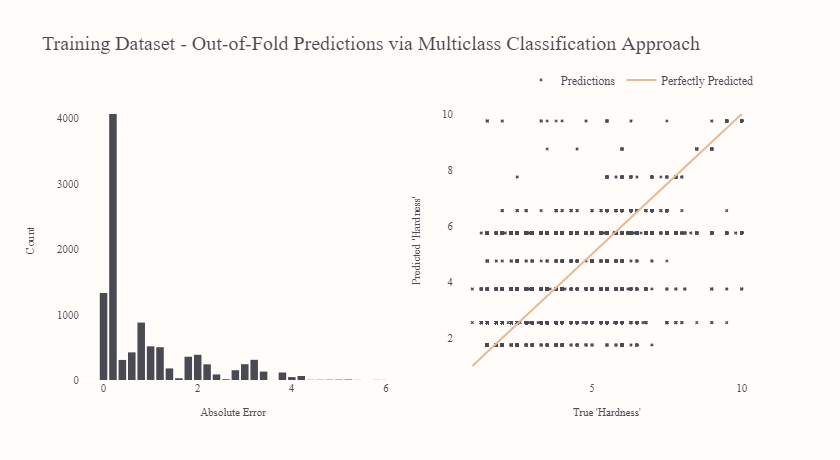

In [49]:
fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.1)

fig.add_histogram(
    x=np.abs(y - y_oof),
    xbins=go.histogram.XBins(size=0.2),
    showlegend=False,
    row=1,
    col=1,
)
fig.update_xaxes(title="Absolute Error", range=(-0.5, 6), row=1, col=1)
fig.update_yaxes(title="Count", row=1, col=1)
fig.add_scatter(
    x=y,
    y=y_oof,
    mode="markers",
    showlegend=True,
    name="Predictions",
    marker=dict(symbol="x", size=3, color=COLOR_SCHEME[0]),
    row=1,
    col=2,
)
fig.add_scatter(x=[1, 10], y=[1, 10], name="Perfectly Predicted", mode="lines", row=1, col=2)
fig.update_yaxes(title="Predicted 'Hardness'", row=1, col=2)
fig.update_xaxes(title="True 'Hardness'", row=1, col=2)
fig.update_layout(
    title="Training Dataset - Out-of-Fold Predictions via Multiclass Classification Approach",
    height=460,
    width=840,
    bargap=0.2,
    legend=dict(y=1.02, x=1),
)
save_and_show_fig(fig, "out_of_fold_preds_classif")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Classification Approach</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Obviously, this approach looks much better in the CV, but what will happen for private LB?
</p>

In [50]:
cats = np.array([1.75, 2.55, 3.75, 4.75, 5.75, 6.55, 7.75, 8.75, 9.75])
encoder = LabelEncoder()

X_train = preprocessing.fit_transform(train.drop("Hardness", axis=1))
X_test = preprocessing.transform(test)
y_train = encoder.fit_transform(round_to_nearest(train.Hardness, cats))

lgb = LGBMClassifier(random_state=42, max_depth=3, verbose=-1)
xgb = XGBClassifier(random_state=42, max_depth=3)

lgb.fit(X_train, y_train)  # type: ignore
xgb.fit(X_train, y_train)

lgb_proba = lgb.predict_proba(X_test)
xgb_proba = xgb.predict_proba(X_test)

y_cat = np.argmax(lgb_proba + xgb_proba, axis=1)
y_pred = encoder.inverse_transform(y_cat)

submission = pd.DataFrame(
    {
        "id": test.index,
        "Hardness": y_pred,
    }
).set_index("id")

submission.to_csv("submission_classif.csv")
get_pretty_frame(submission.head(), precision=2)

,Hardness
id,
10407,2.55
10408,2.55
10409,5.75
10410,5.75
10411,5.75


# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">6</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Summary</span></b><a class="anchor" id="summary"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    That's all in this notebook, and if you read this, leave an upvote if you like it. Good luck!
</p>